#CS145 Project 1: Stack Overflow Success Dynamics: Reputation, Prestige, and Trend Adoption

## Author
* *Mona Anvari, SUNet ID: ####*

# Section 1: Project Overview

## Motivation

Stack Overflow is one of the world's largest developer communities, where
millions of users ask and answer technical questions. Understanding what drives
"success" on this platform measured through upvotes, accepted answers, and
reputation, can reveal important patterns about:

- How users overcome initial failures
- Whether prestige creates bias in community voting
- How experienced users engage with emerging technologies

This project uses Stack Overflow's public BigQuery dataset (50GB+) to explore
these dynamics across multiple interconnected tables: posts_questions,
posts_answers, users, badges, comments, and votes.

## Central Questions

This project investigates three key questions about user success and engagement
on Stack Overflow:

### Question 1: Can users overcome weak first impressions?
**Motivation:** First posts often fail. Do some users overcome bad starts to
achieve high reputation? What behaviors separate those who persist from those
who quit?

**Approach:**
- IDENTIFY users with weak first posts (score ≤ 0, few answers)
- COMPARE their final reputation tiers
- DETECT behavioral patterns: posting frequency, response timing, quality trends

### Question 2: Does high reputation create prestige bias?
**Motivation:** Do experienced users get more upvotes simply because of their
reputation, even when controlling for answer speed and quality?

**Approach:**
- MEASURE answer speed across reputation tiers
- COMPARE upvotes-per-view for equally fast responders
- DETECT if badges amplify this effect among high-reputation users

### Question 3: Do experienced users lead or follow technology trends?
**Motivation:** When new technologies emerge, do high-reputation users explore
them early, or do they stick with established domains?

**Approach:**
- IDENTIFY rising vs declining tags (2x growth or 50% drop)
- COMPARE early adoption rates by reputation tier
- FIND if high-rep questions in rising tags drive momentum or follow it

Expected findings could help:
- Platform designers set realistic expectations for new users
- Community moderators identify and support struggling contributors
- Researchers understand how online reputation systems affect behavior


This analysis requires joining and aggregating across multiple tables:

| Dataset Component | Tables Used | Purpose |
|------------------|-------------|----------|
| Post Content | posts_questions, posts_answers | Track question/answer performance |
| User Profiles | users | Link reputation to behavior |
| Engagement | votes, comments | Measure community response |
| Achievements | badges | Identify visible status markers |


**Dataset Size:** 50GB+ total, meeting the 500MB+ requirement

**Tables:** 6+ interconnected tables with rich JOIN possibilities

# Section 2: Dataset Analysis

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = "#####"

from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
%%bigquery --project $project_id
-- Show table sizes and row counts in Stack Overflow dataset
SELECT
  table_id,
  ROUND(SUM(row_count)/1e6, 2) AS total_rows_millions,
  ROUND(SUM(size_bytes)/POWER(1024, 3), 2) AS size_gb
FROM
  `bigquery-public-data.stackoverflow.__TABLES__`
GROUP BY
  table_id
ORDER BY
  size_gb DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,table_id,total_rows_millions,size_gb
0,post_history,152.44,113.18
1,posts_questions,23.02,37.17
2,stackoverflow_posts,31.02,29.36
3,posts_answers,34.02,28.62
4,comments,86.75,16.03
5,votes,236.45,7.05
6,users,18.71,3.14
7,badges,46.14,1.96
8,post_links,8.40,0.31
9,posts_tag_wiki,0.06,0.04


## Table Relationships
I am including the most relevant parts of table relationships analysis in this cell. You can look at [this link](https://colab.research.google.com/drive/1R6pe9B3OEbVEtXw3mbY_5J2KqewuXRi5?usp=sharing) if you are interested in reading a more comprehensive initial version of this analysis.

### Core Tables and Keys

**1. posts_questions**
- **Primary Key:** id
- **Foreign Keys:**
  - owner_user_id → users.id (question author)
  - accepted_answer_id → posts_answers.id (chosen best answer)
  - last_editor_user_id → users.id (most recent editor)
- **Key Fields:** title, body, tags, score, view_count, answer_count, creation_date

**2. posts_answers**
- **Primary Key:** id
- **Foreign Keys:**
  - parent_id → posts_questions.id (links answer to question)
  - owner_user_id → users.id (answer author)
  - last_editor_user_id → users.id (most recent editor)
- **Key Fields:** body, score, comment_count, creation_date

**3. users**
- **Primary Key:** id
- **Referenced By:** All tables with owner_user_id or user_id columns
- **Key Fields:** display_name, reputation, up_votes, down_votes, creation_date,
  last_access_date
- **Note:** reputation is current value, not historical

**4. votes**
- **Primary Key:** id
- **Foreign Keys:**
  - post_id → posts_questions.id OR posts_answers.id
- **Key Fields:** vote_type_id (2=upvote, 3=downvote), creation_date

**5. badges**
- **Primary Key:** id
- **Foreign Keys:**
  - user_id → users.id
- **Key Fields:** name, class, date, tag_based

**6. comments**
- **Primary Key:** id
- **Foreign Keys:**
  - post_id → posts_questions.id OR posts_answers.id
  - user_id → users.id
- **Key Fields:** text, score, creation_date

## Data Issues and Limitations

### 1. Temporal Challenges

| Issue | Impact | Our Approach |
|-------|--------|--------------|
| users.reputation is current, not historical | Can't directly see rep at answer time | Calculate historical rep from prior vote counts |
| Dataset snapshot ends ~2022 | Can't analyze 2023+ trends | Focus on 2018-2021 period |
| Deleted posts leave orphaned references | Some parent_id or post_id won't match | Filter with JOIN instead of assuming all match |

### 2.Null Value Patterns

| Column | Why It Matters |
|--------|----------------|
| posts_questions.accepted_answer_id | Many questions never get accepted answers |
| users.owner_user_id| Anonymous or deleted users |
| badges.date  | Should be reliable for temporal analysis |
| users.location | Self-reported, inconsistent formatting |

### 3. Data Quality Considerations

**Score Bias:**
- Older posts have more time to accumulate votes
- View count heavily influencial (viral posts dominate)
- Use score-per-view ratios to normalize

**Tag Formatting:**
- Stored as pipe-delimited strings: "python|pandas|dataframe"
- Need UNNEST(SPLIT(tags, '|')) to analyze individual tags
- Some questions have 5+ tags, others just 1

**Reputation Calculation:**
- Simple approximation: (upvotes × 10) - (downvotes × 2)
- Real calculation includes factoring accepted answers, ...
- Good enough for tier comparisons (High vs Medium vs Low)

**Sample Size Requirements:**
- Focus on 2020-2021 for manageable query costs
- Use HAVING clauses to filter low-activity users/tags
- Minimum thresholds: 5 posts per user

# Section 3: Get Your Feet Wet

Debug Tabls for the following queries:
* Subquery 1: Veterans Underperforming Their Average
* Subquery 2: When the Student Outperforms the Teacher

## Subqueries

### Subquery 1: Veterans Underperforming Their Average

Find experienced users whose recent posts score below their historical average.
This uses a CORRELATED subquery where the inner query references the outer
query's user (u.id) to calculate that specific user's past performance. Even high-reputation users have off days. This query helps identify if veterans are struggling with new topics or declining engagement.

**Debug table follows** Note in the final result, we are selecting the `u.display_name` instead of `user_id` for human readability.

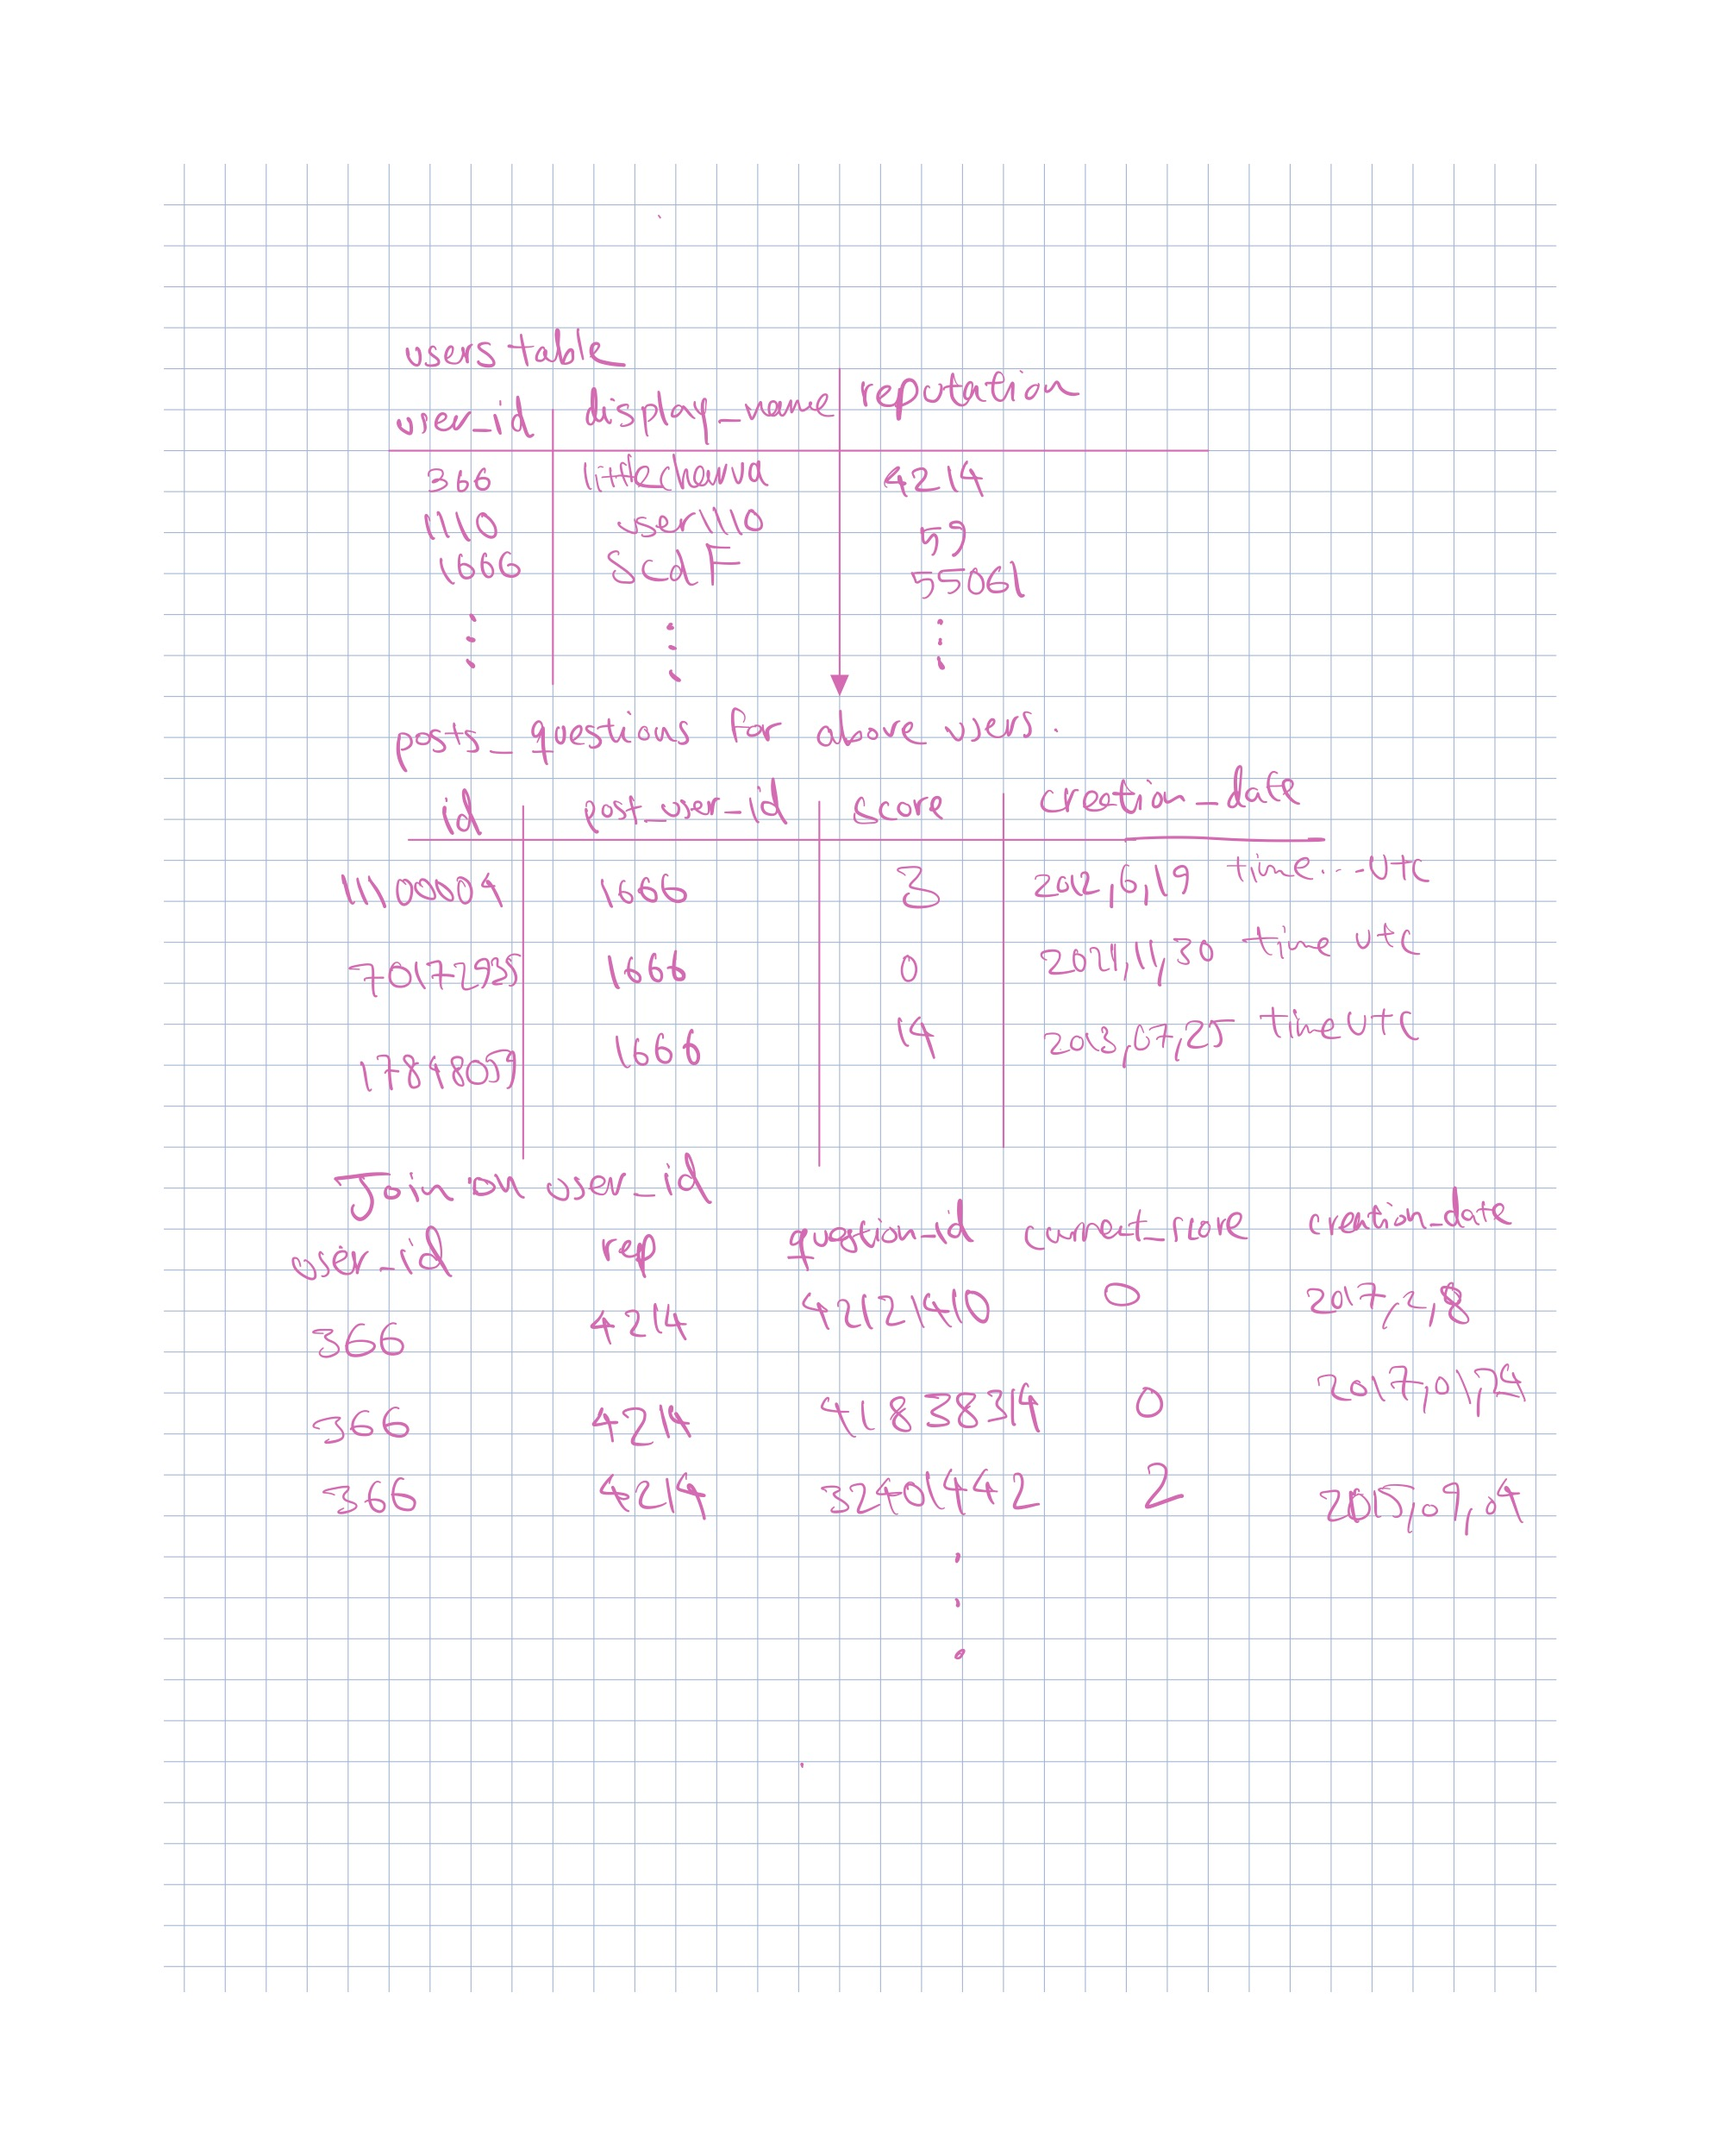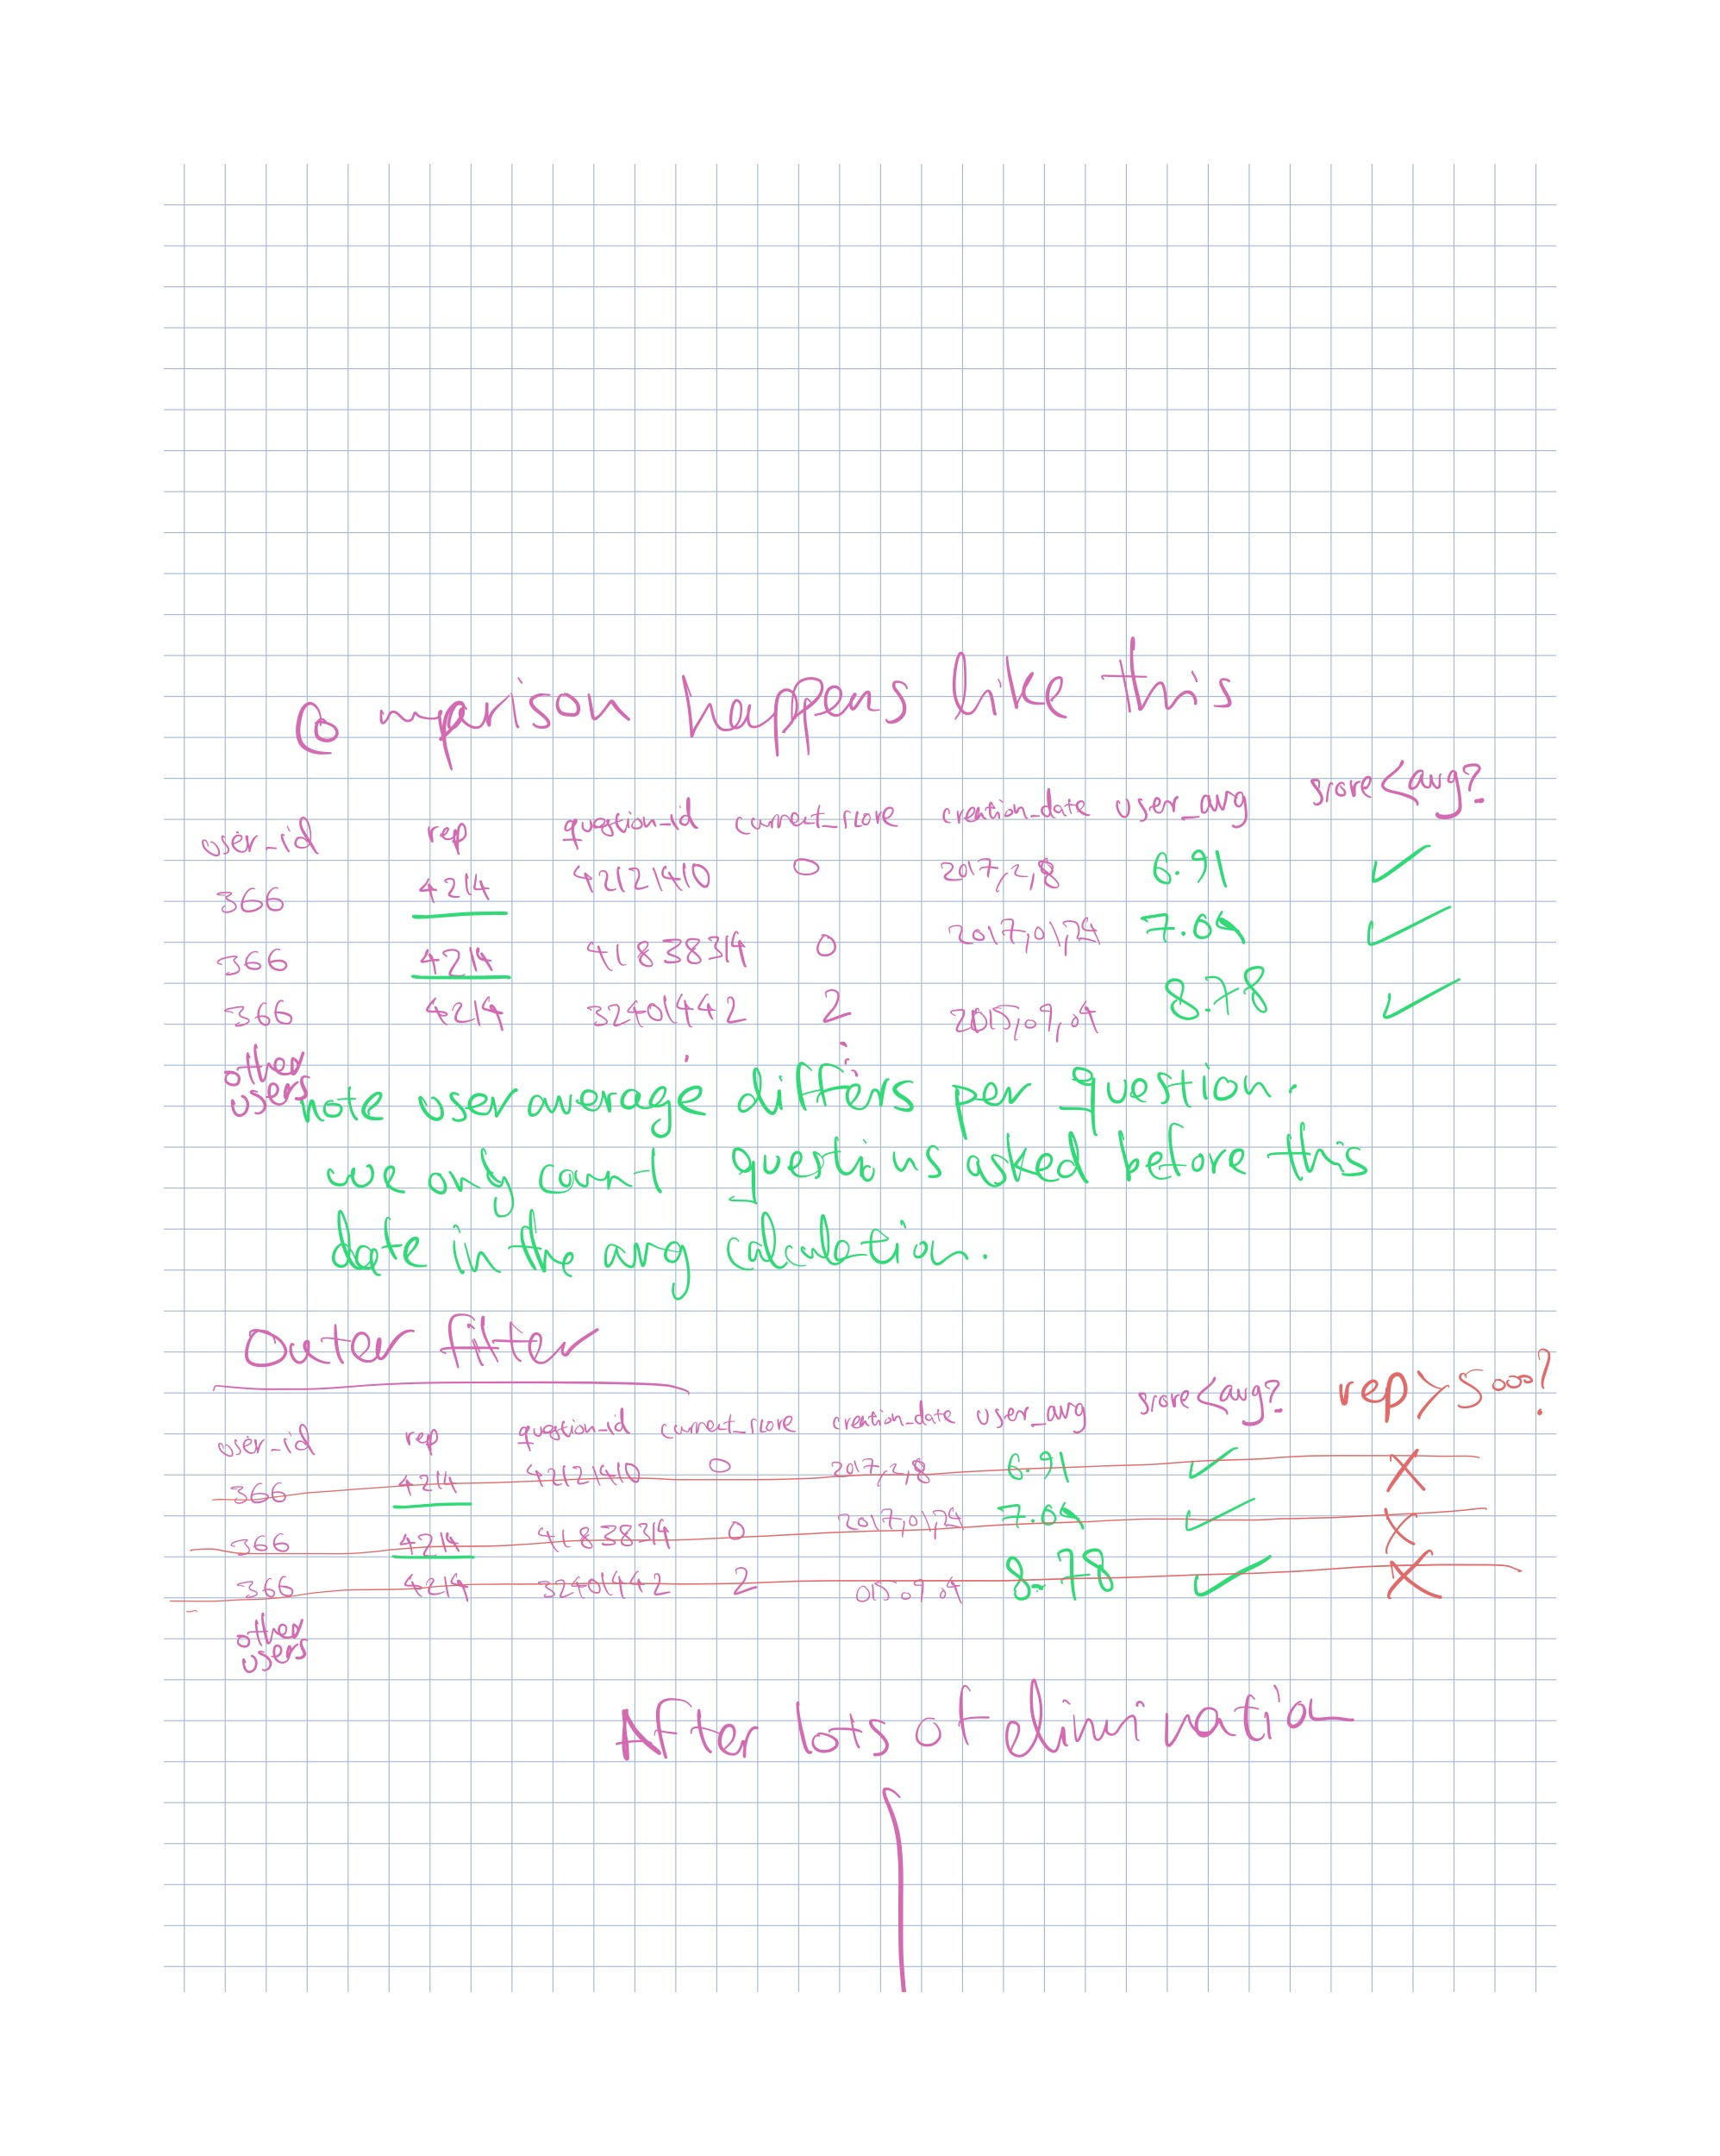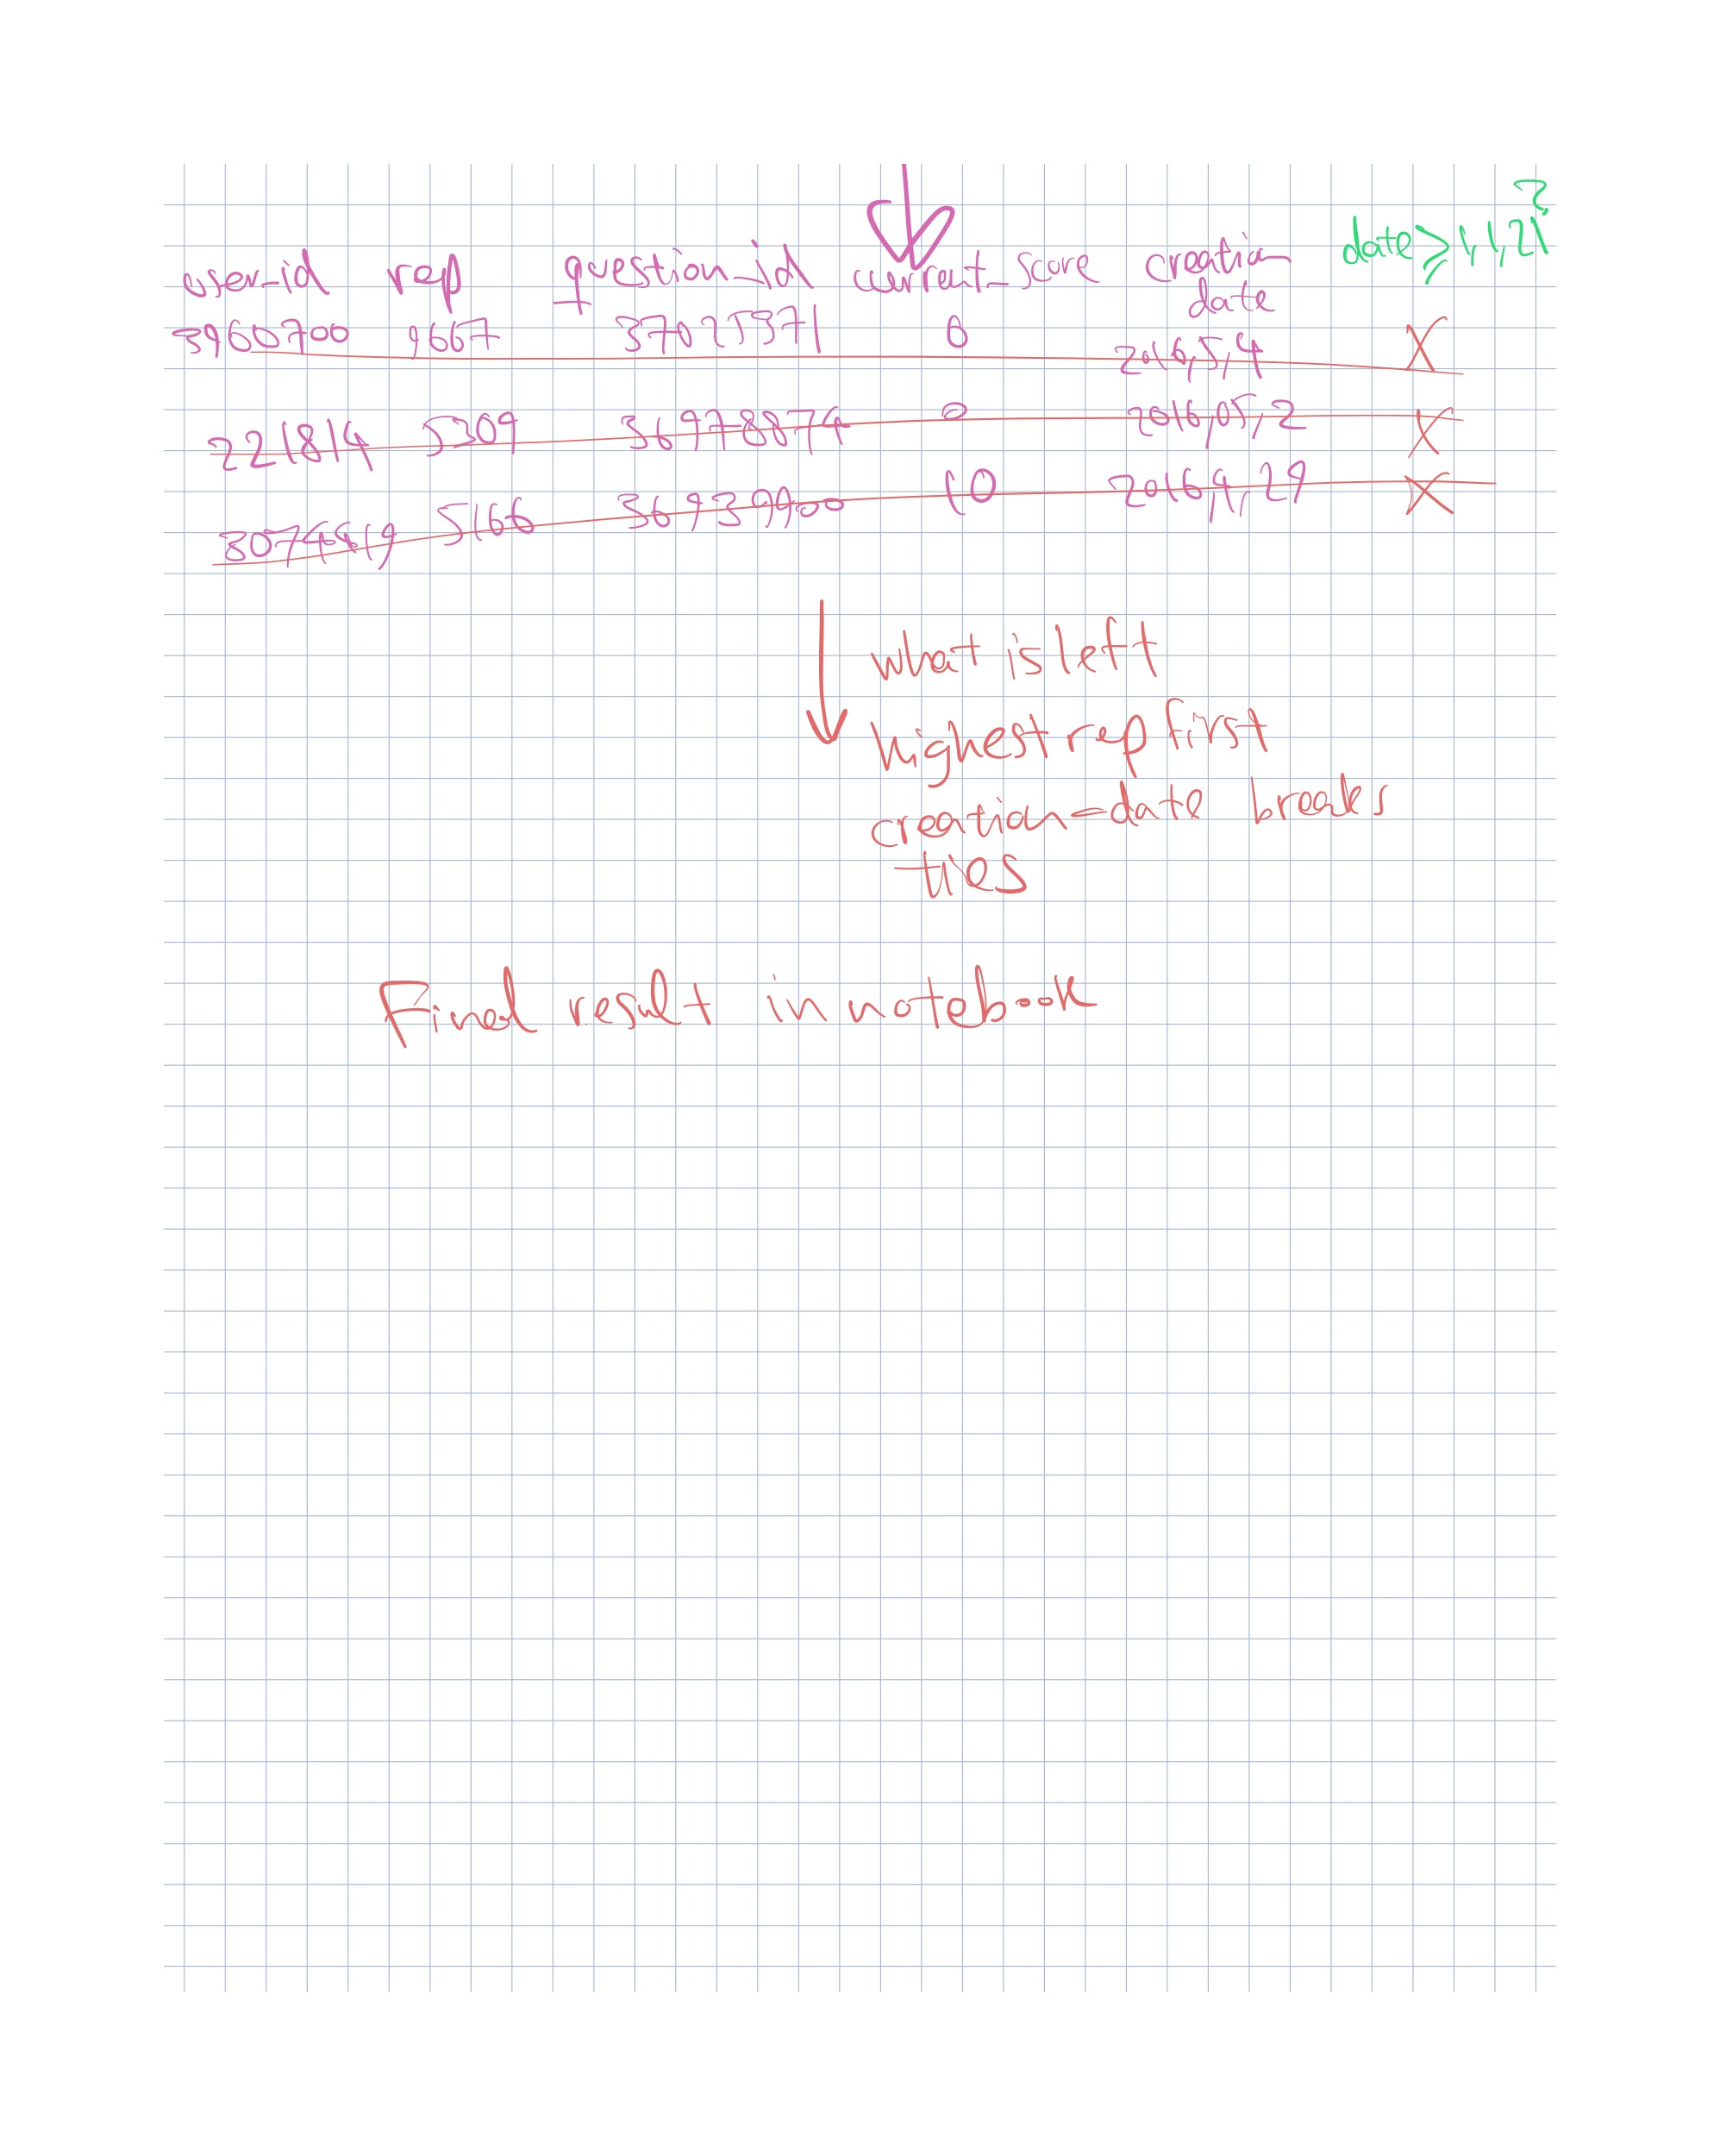



In [ ]:
%%bigquery --project $project_id
SELECT
    u.display_name,
    u.reputation,
    q.id as question_id,
    q.score as current_score,
    q.creation_date
FROM `bigquery-public-data.stackoverflow.users` u
JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON u.id = q.owner_user_id
WHERE q.score < (
    -- CORRELATED: For THIS specific user, get their historical average
    SELECT AVG(q2.score)
    FROM `bigquery-public-data.stackoverflow.posts_questions` q2
    WHERE q2.owner_user_id = u.id  -- References outer scope
        AND q2.creation_date < q.creation_date  -- Only prior posts
)
    AND u.reputation > 5000  -- Focus on experienced users
    AND q.creation_date >= '2021-01-01'
ORDER BY u.reputation DESC, q.creation_date DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,display_name,reputation,question_id,current_score,creation_date
0,Jon Skeet,1357603,73831867,2,2022-09-23 18:55:13.837000+00:00
1,Jon Skeet,1357603,71810199,25,2022-04-09 17:08:12.257000+00:00
2,Marc Gravell,989863,67351269,6,2021-05-01 22:09:15.183000+00:00
3,T.J. Crowder,980540,73142452,0,2022-07-27 17:43:50.307000+00:00
4,T.J. Crowder,980540,73142278,0,2022-07-27 17:29:28.917000+00:00
5,T.J. Crowder,980540,73090669,6,2022-07-23 12:17:20.817000+00:00
6,T.J. Crowder,980540,72953864,1,2022-07-12 14:19:43.167000+00:00
7,T.J. Crowder,980540,67834191,-1,2021-06-04 08:44:09.937000+00:00
8,T.J. Crowder,980540,67582310,0,2021-05-18 08:10:44.070000+00:00
9,T.J. Crowder,980540,67003094,6,2021-04-08 11:31:07.597000+00:00


### Subquery 2: When the Student Outperforms the Teacher

Find answers where the responder's answer score exceeds the questioner's typical performance. The CORRELATED subquery calculates the question author's average question score to use as a benchmark. High-quality answers often come from responders who outperform  the question author's usual contributions. This could indicate knowledge transfer  from experienced users to those still learning.


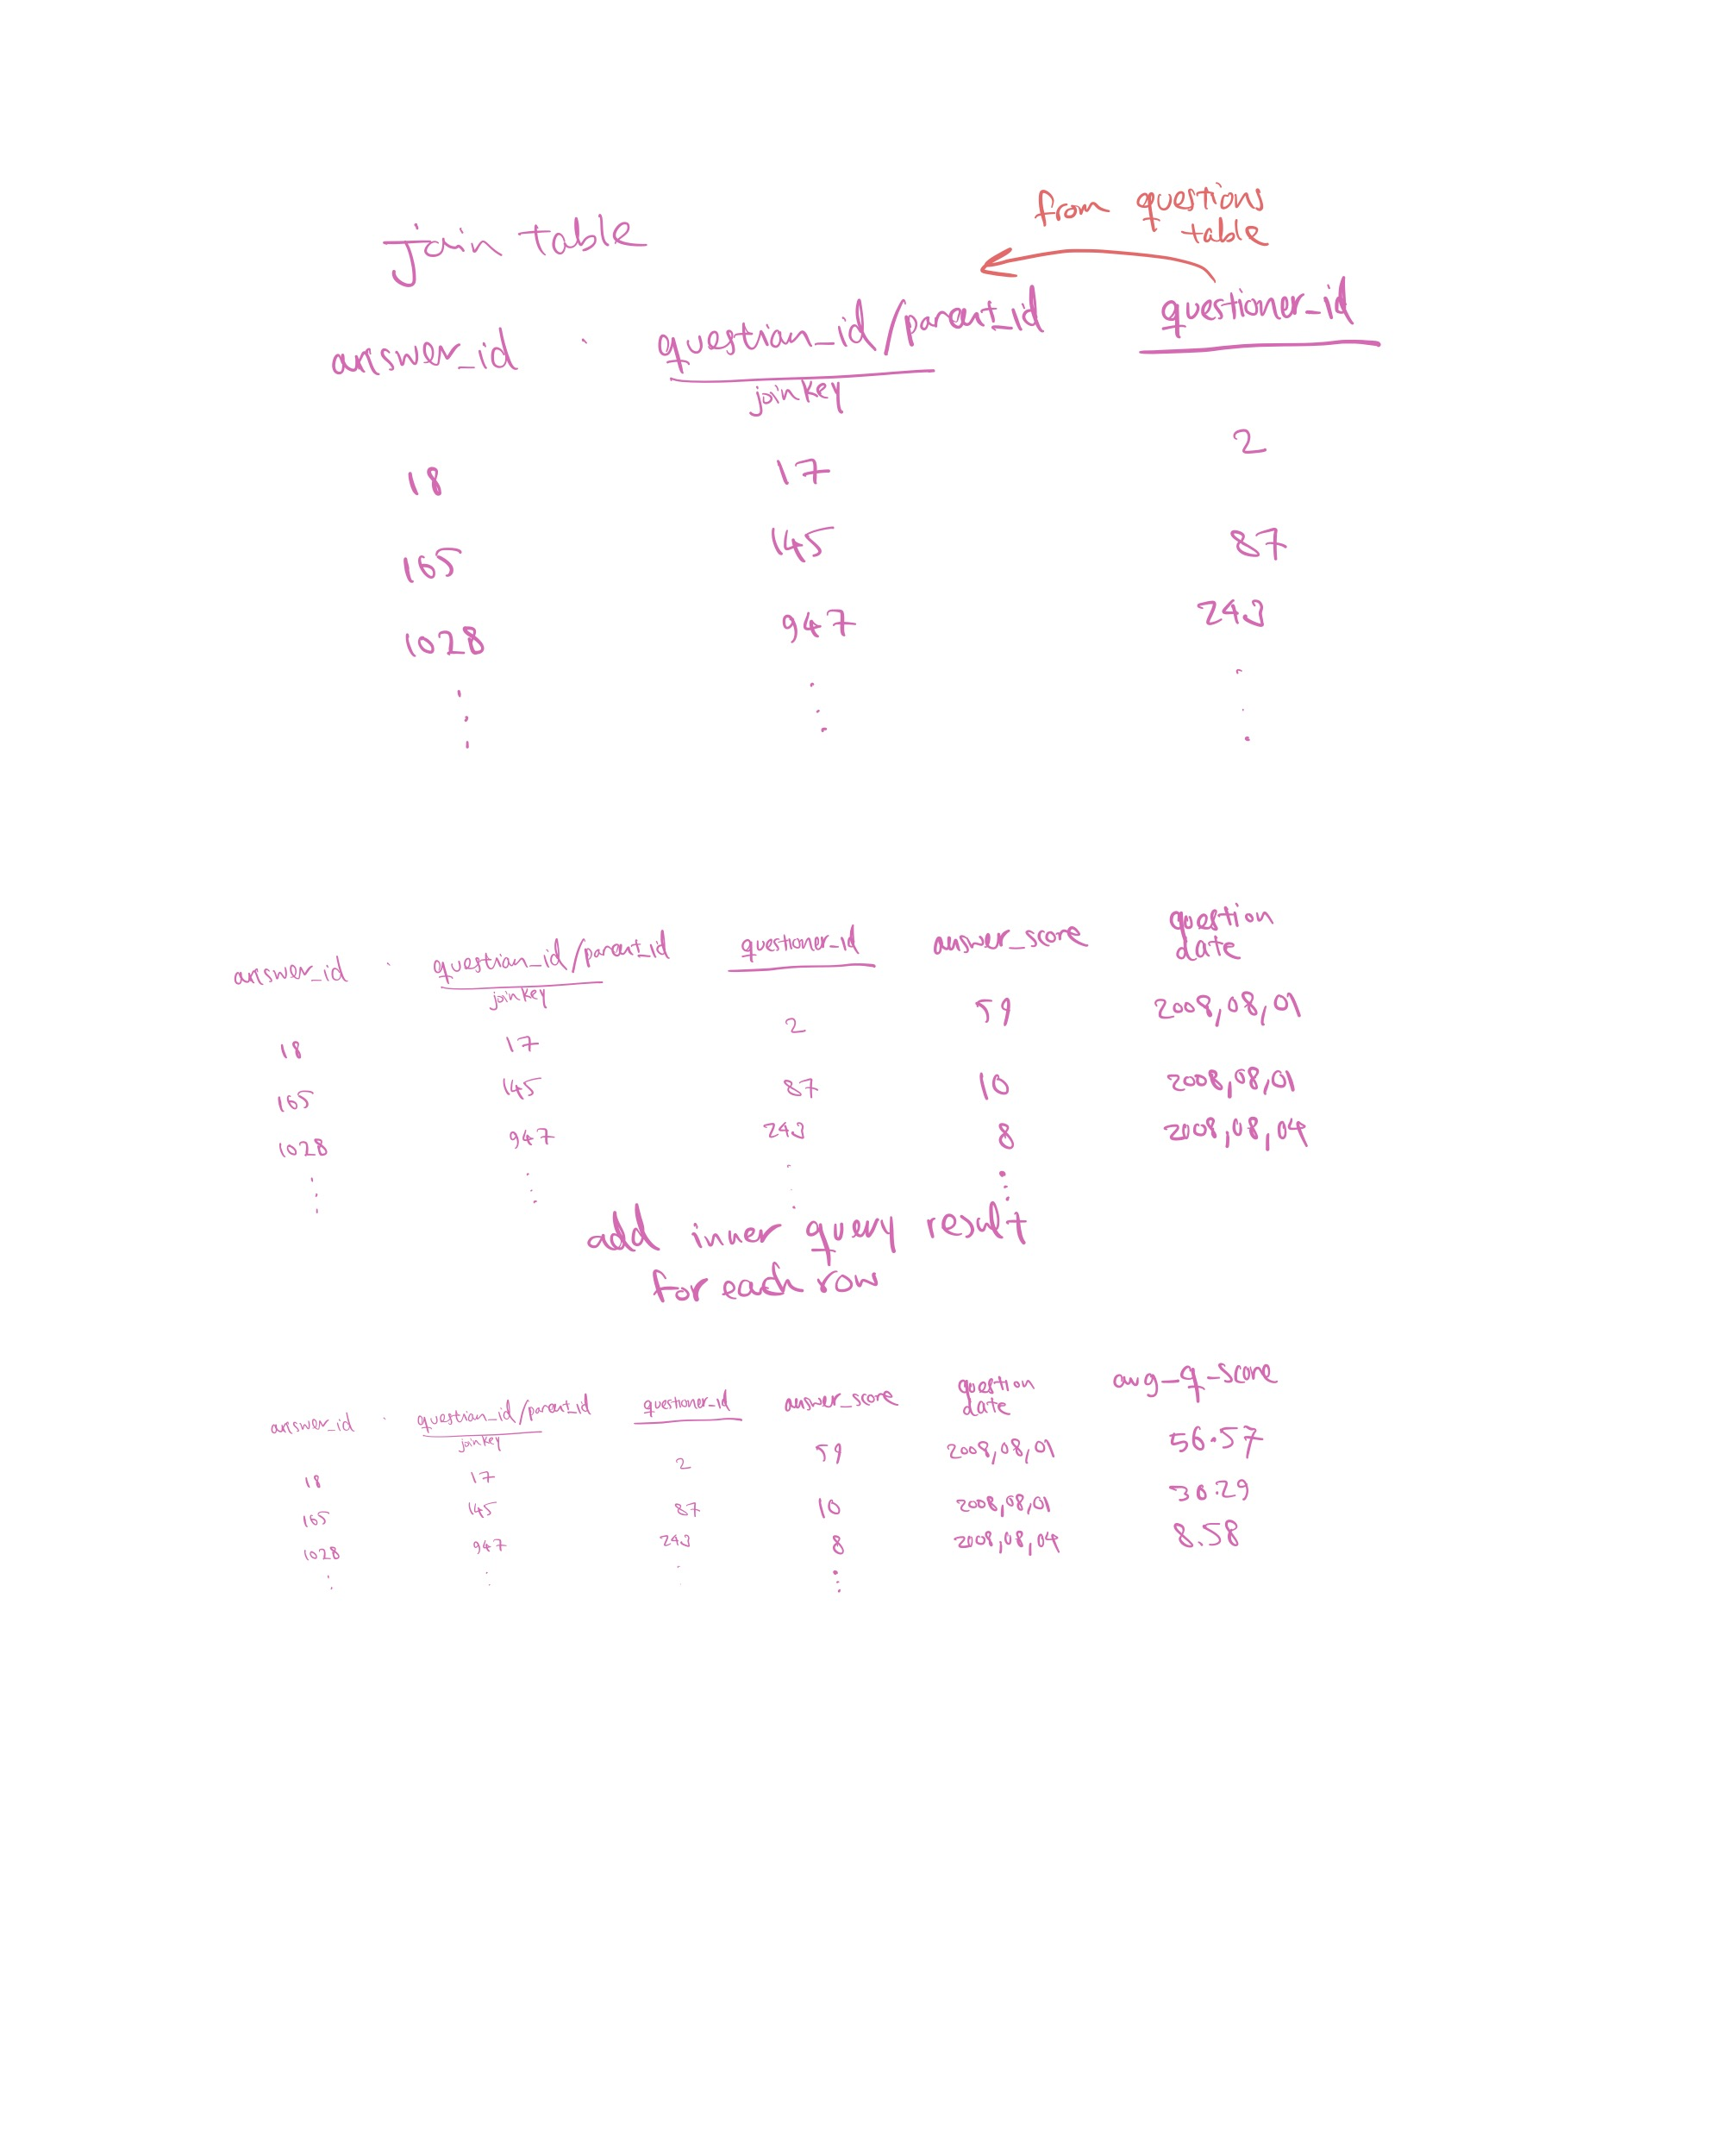

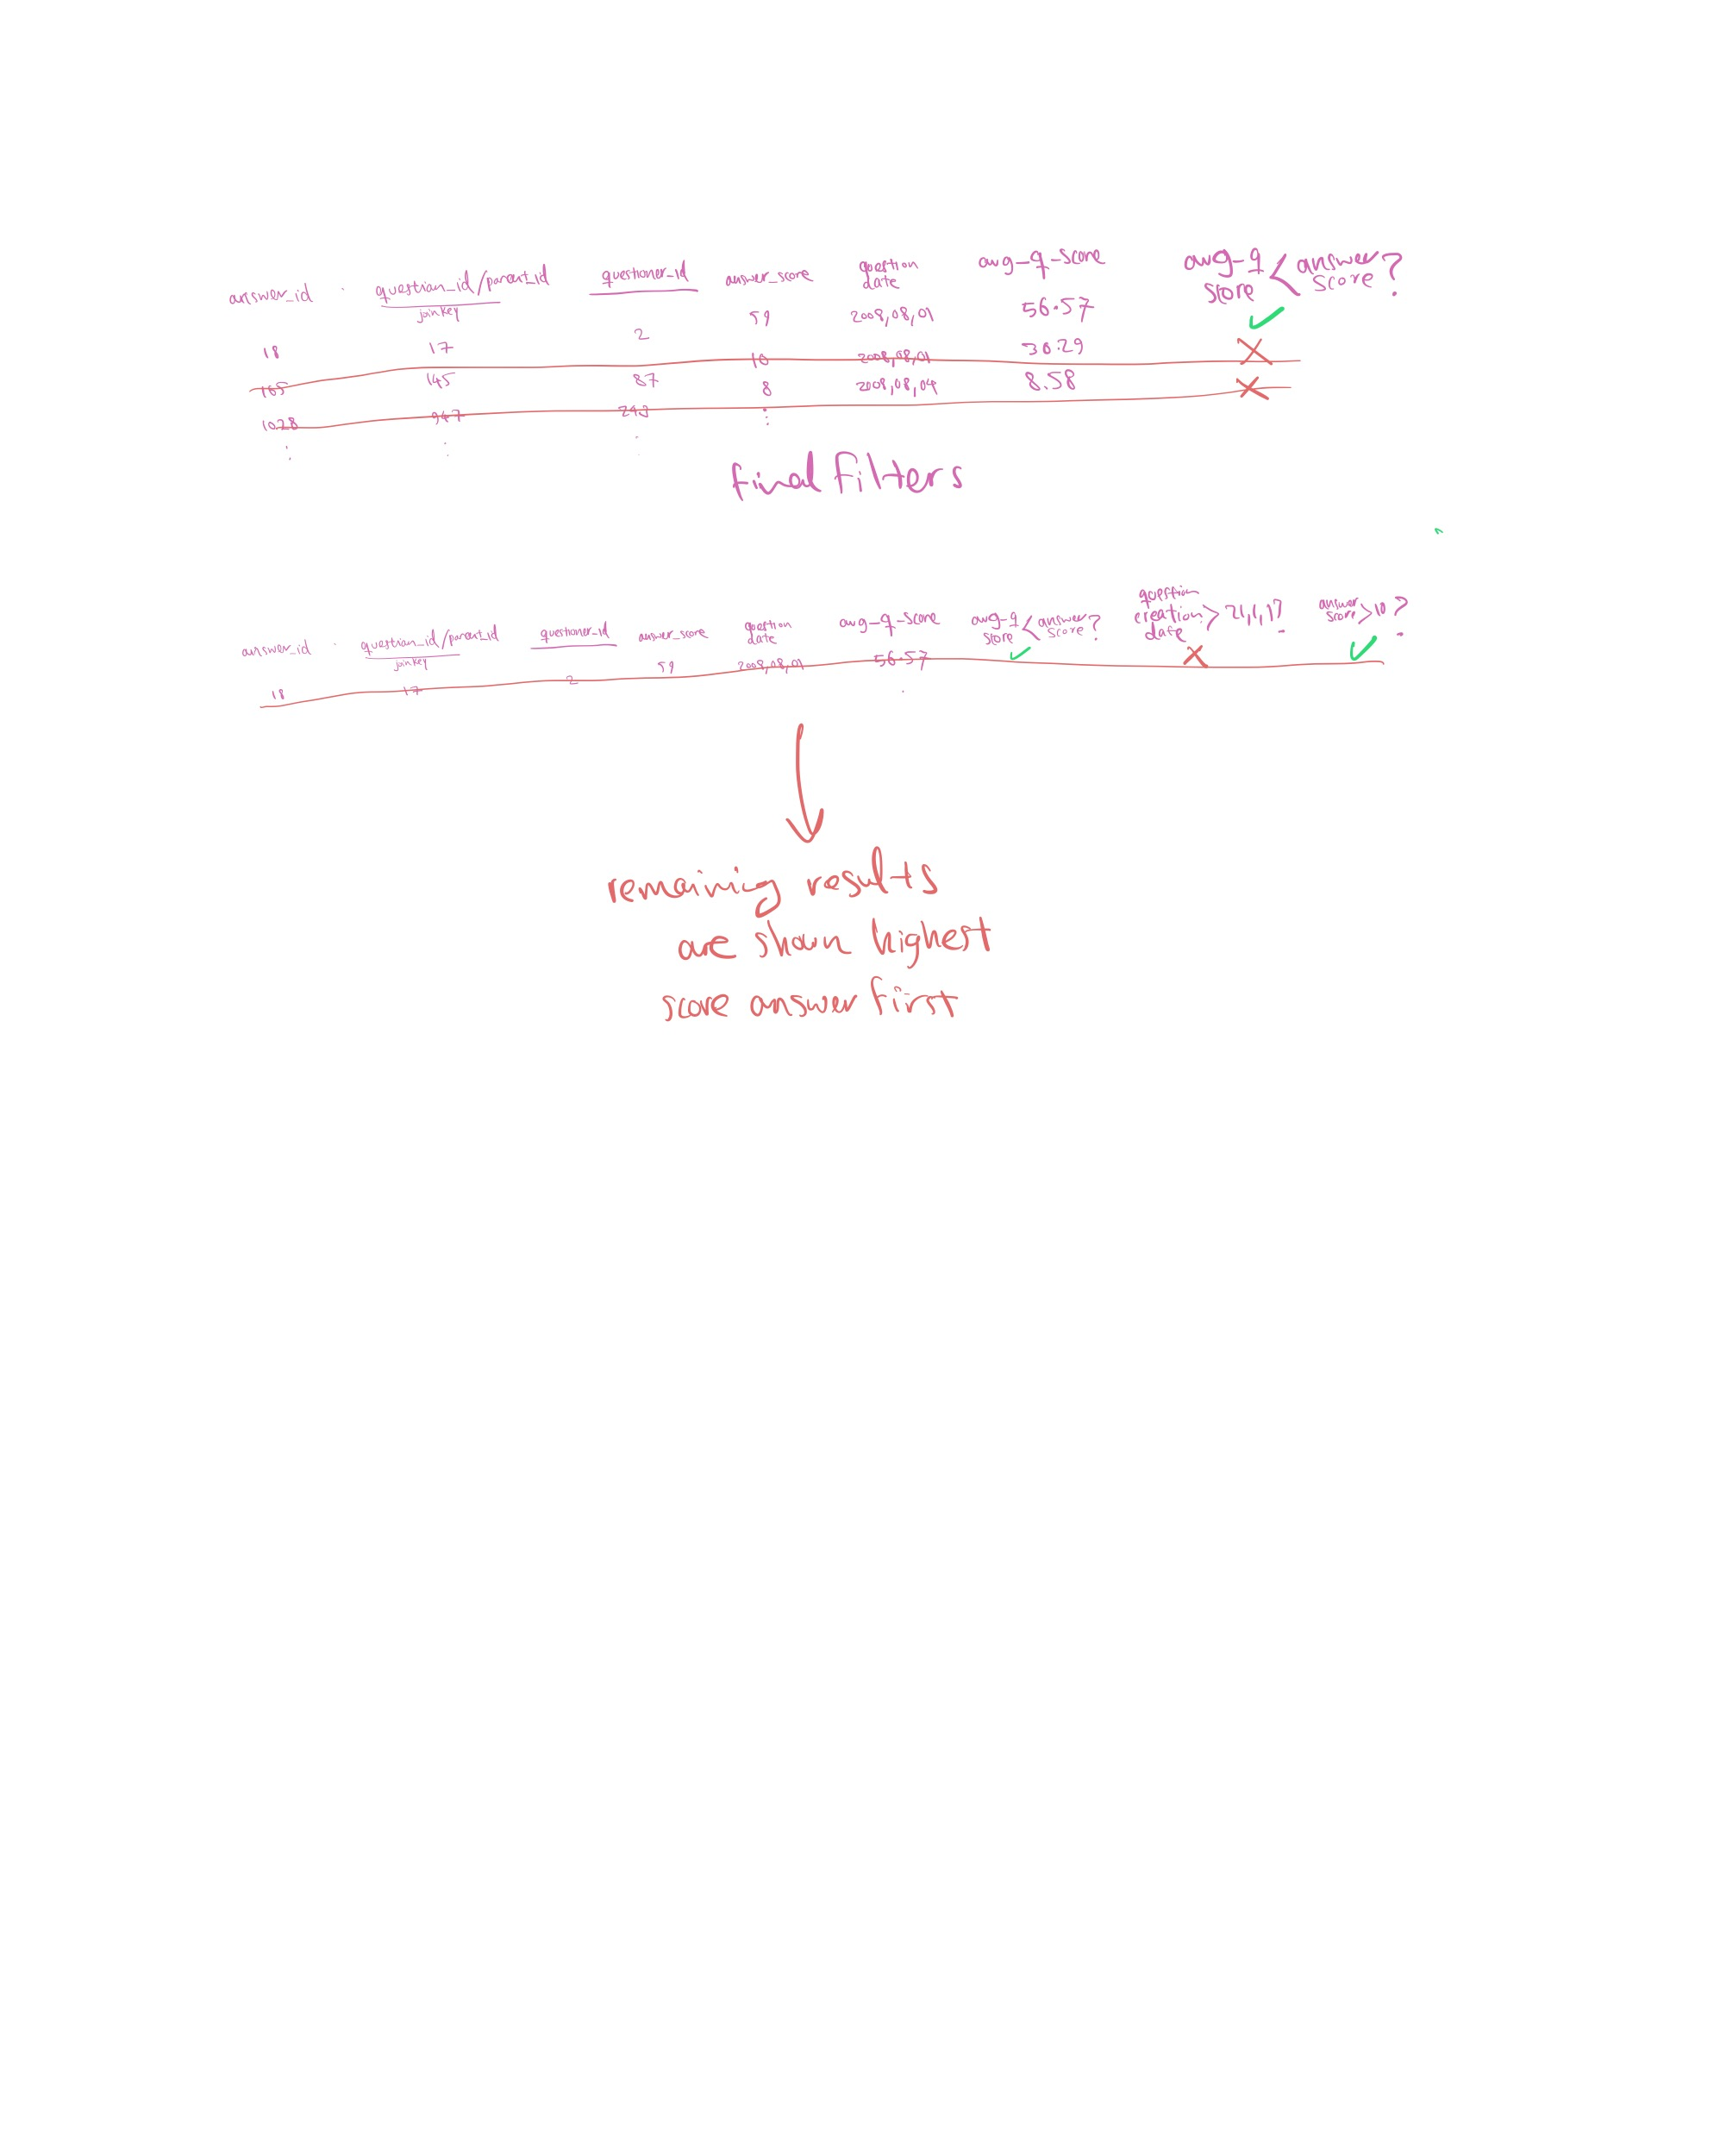

In [ ]:
%%bigquery --project $project_id
-- Find high-quality answers to questions from users who typically get lower engagement
-- Purpose: Identify answers that significantly outperform the questioner's average
SELECT
    a.id as answer_id,
    a.owner_user_id as answerer_id,
    a.body as answer_text,
    q.owner_user_id as questioner_id,
    a.score as answer_score,
    q.score as question_score,
    q.creation_date
FROM `bigquery-public-data.stackoverflow.posts_answers` a
JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id  -- Link each answer to its parent question
WHERE a.score > (
    -- Correlated subquery: Calculate questioner's average question score
    -- This runs once per row, comparing to the specific questioner's history
    SELECT AVG(q2.score)
    FROM `bigquery-public-data.stackoverflow.posts_questions` q2
    WHERE q2.owner_user_id = q.owner_user_id  -- Match outer query's questioner
)
    AND q.creation_date >= '2021-01-01'  -- Recent questions only
    AND a.score > 10  -- Filter for high-quality answers
ORDER BY a.score DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,answer_id,answerer_id,answer_text,questioner_id,answer_score,question_score,creation_date
0,68781050,4575350,"<p>From August 13, 2021, GitHub is no longer a...",15573670,1544,1206,2021-08-13 16:49:34.937000+00:00
1,67002271,6690664,<p>Make sure that your Gradle is using the pro...,11899911,1150,694,2021-04-07 06:17:01.410000+00:00
2,68430992,16475264,"<p>First of all, I faced this issue in Android...",11957368,1074,444,2021-07-15 02:45:41.303000+00:00
3,70365300,17684261,<p>Try running this:</p>\n<pre><code>npx clear...,14426381,862,220,2021-12-15 04:58:02.777000+00:00
4,69699772,8243653,<p>Here are two options now -</p>\n<p><strong>...,14994086,803,630,2021-10-23 23:39:57.517000+00:00
5,69437989,1062587,<p>As a first test to check if everything is j...,8612435,774,224,2021-06-09 08:49:35.190000+00:00
6,66087132,3489524,"<p>Similar to what @KostDM said, in my case it...",14337399,668,331,2021-02-06 21:58:06.040000+00:00
7,66650266,15405505,<p>What fixed the issue for me is going to Too...,11124332,594,283,2021-03-14 21:43:50.273000+00:00
8,68492909,8131914,<p>The solution for me was opening Android Stu...,11993020,545,272,2021-07-03 11:50:25.497000+00:00
9,67659159,13230118,<p><strong>Delete the <code>.next</code> folde...,15988162,522,188,2021-05-22 17:55:10.053000+00:00


## CTEs

### CTE 1: Does Engagement Plateau After the Honeymoon Period or Do Experienced Users Maintain an Edge in Driving Engagement?
Track how user engagement evolves across career phases using multi-step CTE logic. This CTE logic detect if later posts get more/less engagement than early posts.

In [ ]:
%%bigquery --project $project_id
WITH user_post_timeline AS (
    -- Step 1: Rank all posts by each user chronologically
    -- This creates a numbered sequence (1st post, 2nd post, ...) for each user
    SELECT
        owner_user_id,
        id as post_id,
        score,
        comment_count,
        answer_count,  -- Number of answers received per question
        creation_date,
        ROW_NUMBER() OVER (
            PARTITION BY owner_user_id  -- Separate numbering per user
            ORDER BY creation_date      -- Number posts from oldest to newest
        ) as post_sequence
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE owner_user_id IS NOT NULL
        AND creation_date >= '2020-01-01'
),

career_phases AS (
    -- Step 2: Categorize posts into career phases based on sequence number
    -- Early posts (1-5) vs mid-career (6-20) vs established users (20+)
    SELECT
        owner_user_id,
        post_id,
        score,
        comment_count,
        answer_count,
        CASE
            WHEN post_sequence <= 5 THEN 'Early Career (1-5)'
            WHEN post_sequence <= 20 THEN 'Mid Career (6-20)'
            ELSE 'Established (20+)'
        END as career_phase
    FROM user_post_timeline
)

-- Step 3: Compare average engagement across career phases
-- If metrics increase with career_phase, suggests reputation builds momentum
SELECT
    career_phase,
    COUNT(*) as post_count,
    ROUND(AVG(score), 2) as avg_score,
    ROUND(AVG(comment_count), 2) as avg_comments,
    ROUND(AVG(answer_count), 2) as avg_answers  -- How many answers questions receive
FROM career_phases
GROUP BY career_phase
ORDER BY
    CASE career_phase  -- Custom sort to maintain logical order
        WHEN 'Early Career (1-5)' THEN 1
        WHEN 'Mid Career (6-20)' THEN 2
        ELSE 3
    END;

Query is running:   0%|          |

Downloading:   0%|          |

,career_phase,post_count,avg_score,avg_comments,avg_answers
0,Early Career (1-5),3322521,0.48,1.92,1.01
1,Mid Career (6-20),943723,0.54,1.92,1.05
2,Established (20+),427267,0.59,1.89,1.06


### CTE 2: Identifying Technologies in Their "Golden Hour"

This query tracks monthly engagement and growth trends for major programming languages. Tags with both high growth_pct and high avg_score are in their
"golden hour" where rising interest meets quality content. This helps identify
emerging technologies worth learning.

In [ ]:
%%bigquery --project $project_id
WITH monthly_tag_activity AS (
    -- Step 1: Aggregate tag usage and engagement by month
    SELECT
        EXTRACT(YEAR FROM q.creation_date) as year,
        EXTRACT(MONTH FROM q.creation_date) as month,
        tag,
        COUNT(*) as question_count,
        AVG(q.score) as avg_score,
        AVG(q.answer_count) as avg_answers
    FROM `bigquery-public-data.stackoverflow.posts_questions` q,
    UNNEST(SPLIT(q.tags, '|')) as tag  -- Split 'python|django|web' into separate rows
    WHERE q.creation_date >= '2020-01-01'
        AND tag IN ('python', 'javascript', 'rust', 'typescript', 'go')  -- Focus on specific tags
    GROUP BY year, month, tag
),

tag_trends AS (
    -- Step 2: Calculate month-over-month growth using window functions
    -- LAG() retrieves the previous month's count for the same tag
    SELECT
        tag,
        year,
        month,
        question_count,
        LAG(question_count) OVER (
            PARTITION BY tag  -- Separate trend line per tag
            ORDER BY year, month  -- Look back chronologically
        ) as prev_month_count,
        avg_score
    FROM monthly_tag_activity
)

-- Step 3: Calculate growth percentage and identify momentum
-- High growth_pct + high avg_score indicates rising interest and quality engagement
SELECT
    tag,
    year,
    month,
    question_count,
    prev_month_count,
    ROUND(100.0 * (question_count - prev_month_count) / NULLIF(prev_month_count, 0), 2) as growth_pct,
    ROUND(avg_score, 2) as avg_score
FROM tag_trends
WHERE prev_month_count IS NOT NULL  -- Skip first month since no prior data
ORDER BY growth_pct DESC, avg_score DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,tag,year,month,question_count,prev_month_count,growth_pct,avg_score
0,go,2021,3,761,571,33.27,0.58
1,rust,2021,3,572,433,32.10,1.50
2,rust,2021,12,662,506,30.83,1.30
3,rust,2020,12,476,372,27.96,1.76
4,rust,2020,4,455,363,25.34,2.10
5,go,2021,8,747,604,23.68,0.10
6,go,2020,4,796,653,21.90,0.67
7,python,2020,4,27627,22684,21.79,0.60
8,typescript,2021,3,3090,2538,21.75,0.83
9,go,2022,3,828,688,20.35,0.71


## Window Functions

### Window Function 1: Top Contributors in Each Technology Niche

This query ranks users within their primary language communities using RANK(). Top contributors vary by language. Python has different leaders than Rust. Specialization matters more than general reputation.

In [ ]:
%%bigquery --project $project_id
WITH user_tag_activity AS (
    -- Calculate user contribution metrics per tag
    SELECT
        q.owner_user_id,
        u.display_name,
        tag,
        COUNT(*) as questions_posted,
        SUM(q.score) as total_score,
        AVG(q.score) as avg_score
    FROM `bigquery-public-data.stackoverflow.posts_questions` q
    JOIN `bigquery-public-data.stackoverflow.users` u
        ON q.owner_user_id = u.id,
    UNNEST(SPLIT(q.tags, '|')) as tag
    WHERE q.creation_date >= '2020-01-01'
        AND tag IN ('python', 'javascript', 'java', 'c++', 'rust')
    GROUP BY owner_user_id, display_name, tag
    HAVING questions_posted >= 5
),
ranked_users AS (
    -- Rank users within each tag community
    SELECT
        tag,
        display_name,
        questions_posted,
        total_score,
        ROUND(avg_score, 2) as avg_score,
        RANK() OVER (
            PARTITION BY tag
            ORDER BY total_score DESC
        ) as score_rank,  -- RANK: allows ties, skips numbers. We care about true positions relative to others.
        DENSE_RANK() OVER (
            PARTITION BY tag
            ORDER BY questions_posted DESC
        ) as volume_rank  -- DENSE_RANK: no gaps after ties. We do not care about true positions relative to others
    FROM user_tag_activity
)
SELECT
    tag,
    display_name,
    questions_posted,
    total_score,
    avg_score,
    score_rank,
    volume_rank
FROM ranked_users
WHERE score_rank <= 10
ORDER BY tag, score_rank
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,tag,display_name,questions_posted,total_score,avg_score,score_rank,volume_rank
0,c++,Fedor,187,1230,6.58,1,1
1,c++,xmh0511,163,690,4.23,2,3
2,c++,NoSenseEtAl,168,546,3.25,3,2
3,c++,康桓瑋,85,487,5.73,4,16
4,c++,einpoklum,142,484,3.41,5,5
5,c++,xmllmx,112,474,4.23,6,10
6,c++,HolyBlackCat,40,405,10.13,7,40
7,c++,Enlico,136,357,2.63,8,7
8,c++,cigien,53,340,6.42,9,29
9,c++,Jason Liam,118,298,2.53,10,9


### Window Function 2: When Are Users "In the Zone"?
Track answer streaks using rolling averages to identify hot/cold performance phases. Users experience momentum cycles. Identifying "cold spells"
early could help platforms intervene with encouragement or topic suggestions.

In [ ]:
%%bigquery --project $project_id
WITH answer_sequence AS (
    -- Step 1: Number each user's answers chronologically
    SELECT
        owner_user_id,
        id as answer_id,
        score,
        creation_date,
        ROW_NUMBER() OVER (
            PARTITION BY owner_user_id
            ORDER BY creation_date
        ) as answer_number
    FROM `bigquery-public-data.stackoverflow.posts_answers`
    WHERE owner_user_id IS NOT NULL
        AND creation_date >= '2020-01-01'
),
rolling_calculations AS (
    -- Step 2: Calculate 3-answer rolling average
    SELECT
        a1.owner_user_id,
        a1.answer_id,
        a1.answer_number,
        a1.score,
        AVG(a2.score) as rolling_avg_score
    FROM answer_sequence a1
    JOIN answer_sequence a2
        ON a1.owner_user_id = a2.owner_user_id
        AND a2.answer_number <= a1.answer_number
        AND a2.answer_number > a1.answer_number - 3
    GROUP BY a1.owner_user_id, a1.answer_id, a1.answer_number, a1.score
)
-- Step 3: Classify performance phases
SELECT
    owner_user_id,
    answer_id,
    answer_number,
    score,
    ROUND(rolling_avg_score, 2) as rolling_avg_score,
    CASE
        WHEN rolling_avg_score > 5 THEN 'Hot Streak'
        WHEN rolling_avg_score < 1 THEN 'Cold Spell'
        ELSE 'Steady'
    END as performance_phase
FROM rolling_calculations
WHERE answer_number >= 3  -- Need at least 3 answers for rolling average
ORDER BY owner_user_id, answer_number
LIMIT 200; --I wanted to show a wider range, hence the larger limit

Query is running:   0%|          |

Downloading:   0%|          |

,owner_user_id,answer_id,answer_number,score,rolling_avg_score,performance_phase
0,4,59870052,3,1,0.67,Cold Spell
1,4,59870064,4,2,1.00,Steady
2,4,60496056,5,2,1.67,Steady
3,22,73570107,3,0,0.33,Cold Spell
4,22,73570244,4,2,0.67,Cold Spell
...,...,...,...,...,...,...
195,267,70983672,101,1,2.33,Steady
196,267,71037707,102,1,1.33,Steady
197,267,71047368,103,3,1.67,Steady
198,267,71110757,104,0,1.33,Steady


### Window Function 3: Do Badges Break Reputation Ties?
Shows users with identical reputation scores and how their badge counts differ.
Filters to display only reputation values where at least 2 users are tied,
revealing hidden engagement differences among "equal" contributors. If Stack Overflow were to select "top 20 users by reputation" for recognition, using row_num gets exactly 20 users, but arbitrarily picks one from each tie. Using rank_with_gaps gets more than 20 users includes all tied at positions 1-20. Adding badge_count as tie-breaker picks the most consistently engaged user from each tie group.


In [ ]:
%%bigquery --project $project_id
WITH recent_active_users AS (
    -- Get sample of users with similar reputation
    SELECT
        id,
        display_name,
        reputation,
        creation_date
    FROM `bigquery-public-data.stackoverflow.users`
    WHERE creation_date >= '2020-01-01'
        AND reputation BETWEEN 1000 AND 2000
    LIMIT 1000
),
user_badge_counts AS (
    -- Count badges earned by each user
    SELECT
        user_id,
        COUNT(*) as badge_count
    FROM `bigquery-public-data.stackoverflow.badges`
    WHERE date >= '2020-01-01'
    GROUP BY user_id
),
ranked_with_badges AS (
    SELECT
        u.display_name,
        u.reputation,
        COALESCE(b.badge_count, 0) as badge_count,
        -- ROW_NUMBER: Always unique, arbitrary order for ties
        ROW_NUMBER() OVER (ORDER BY u.reputation DESC) as row_num,
        -- RANK: Same rank for ties, creates gaps (1,1,3)
        RANK() OVER (ORDER BY u.reputation DESC) as rank_with_gaps,
        -- DENSE_RANK: Same rank for ties, NO gaps (1,1,2)
        DENSE_RANK() OVER (ORDER BY u.reputation DESC) as dense_rank,
        -- Show how many users share this exact reputation
        COUNT(*) OVER (PARTITION BY u.reputation) as users_at_same_rep
    FROM recent_active_users u
    LEFT JOIN user_badge_counts b
        ON u.id = b.user_id
)
SELECT
    display_name,
    reputation,
    badge_count,
    row_num,
    rank_with_gaps,
    dense_rank,
    users_at_same_rep
FROM ranked_with_badges
WHERE users_at_same_rep > 1  -- Only show users where there's at least one tie
ORDER BY reputation DESC, badge_count DESC, display_name
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,display_name,reputation,badge_count,row_num,rank_with_gaps,dense_rank,users_at_same_rep
0,Saheel Sapovadia,1998,26,2,1,1,2
1,F1ko,1998,24,1,1,1,2
2,Sergey Afinogenov,1967,13,12,11,10,2
3,Saideep Arikontham,1967,10,11,11,10,2
4,Morez,1963,37,15,14,12,2
5,Patrick Hume,1963,12,14,14,12,2
6,angelo,1941,34,20,20,17,2
7,Vitalii,1941,9,21,20,17,2
8,g00se,1923,12,26,26,22,2
9,Anand Gautam,1923,11,27,26,22,2


# Section 4: Exploring Central Questions

## Question 1: IDENTIFY users WHO achieve high reputation DESPITE weak first posts
Many new users post questions that receive little engagement. Do some overcome
this weak start to achieve high reputation? What behaviors distinguish those
who persist and succeed?

### Strategy:
1. Classify first post performance (weak/moderate/strong)
2. Cross-tabulate with final reputation tiers
3. Compare behavioral patterns: posting frequency, timing, ...

### Query 1.1: Classify first post performance across the community
Establish baseline categories for first post performance across the community to create fair comparison groups.

The vast majority of new users experience a "medium start" with on their first post. Only a small percentage achieve a "strong start" (5+ score or 3+ answers). This establishes that medium beginnings are the norm.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 1.1: Establish baseline. What does "success" look like for first posts?
-- Purpose: Create fair categories before comparing trajectories
-- ----------------------------------------------------------------------------

WITH first_posts AS (
  -- Identify each user's debut post
  SELECT
    owner_user_id,
    id as first_post_id,
    score,
    answer_count,
    view_count,
    creation_date,
    ROW_NUMBER() OVER (
      PARTITION BY owner_user_id
      ORDER BY creation_date
    ) as post_rank
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date BETWEEN '2020-01-01' AND '2021-12-31'
  QUALIFY post_rank = 1
),

user_activity AS (
  -- ADDED: Filter to users with 5+ posts (consistent with 1.2 and 1.3)
  SELECT
    owner_user_id,
    COUNT(*) as total_posts
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date >= '2020-01-01'
  GROUP BY owner_user_id
  HAVING total_posts >= 5
)

-- Categorize first post performance
SELECT
  CASE
    WHEN score >= 5 OR answer_count >= 3 THEN 'Strong Start'
    WHEN score >= 1 OR answer_count >= 1 THEN 'Moderate Start'
    ELSE 'Weak Start'
  END as first_post_category,
  COUNT(*) as user_count,
  ROUND(AVG(score), 2) as avg_first_score,
  ROUND(AVG(answer_count), 2) as avg_first_answers,
  ROUND(AVG(view_count), 0) as avg_first_views
FROM first_posts fp
JOIN user_activity ua ON fp.owner_user_id = ua.owner_user_id  -- ADDED
-- REMOVED: WHERE view_count >= 10 (inconsistent with other queries)
GROUP BY first_post_category
ORDER BY
  CASE first_post_category
    WHEN 'Strong Start' THEN 1
    WHEN 'Moderate Start' THEN 2
    ELSE 3
  END;

Query is running:   0%|          |

Downloading:   0%|          |

,first_post_category,user_count,avg_first_score,avg_first_answers,avg_first_views
0,Strong Start,19071,3.44,3.08,2927.0
1,Moderate Start,160083,0.53,1.15,522.0
2,Weak Start,20331,0.00,0.00,179.0


### Query1.2 : DETECT WHO overcomes weak starts to reach high reputation
Cross-tabulate first post quality against final reputation to detect "comeback" users who reached high reputation despite weak debuts.
Among users with weak first posts (score < 1, answer_count < 1) who posted at least 5 questions, only 3% reached high reputation (5k+).

In [ ]:
%%bigquery --project $project_id
-- QUESTION 1.2: Find "comeback stories"
-- ----------------------------------------------------------------------------

WITH first_posts AS (
  -- Get first post performance
  SELECT
    owner_user_id,
    score as first_score,
    answer_count as first_answers,
    creation_date as first_post_date,
    CASE
      WHEN score >= 5 OR answer_count >= 3 THEN 'Strong Start'
      WHEN score >= 1 OR answer_count >= 1 THEN 'Moderate Start'
      ELSE 'Weak Start'
    END as first_post_category
  FROM (
    SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY owner_user_id ORDER BY creation_date) as rn
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE owner_user_id IS NOT NULL
      AND creation_date BETWEEN '2020-01-01' AND '2021-12-31'
  )
  WHERE rn = 1
),

user_activity AS (
  -- Count total posts
  SELECT
    owner_user_id,
    COUNT(*) as total_posts
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date >= '2020-01-01'
  GROUP BY owner_user_id
  HAVING total_posts >= 5
),

final_reputation AS (
  -- Get current reputation (as of dataset snapshot)
  SELECT
    u.id as user_id,
    u.reputation,
    u.up_votes,
    u.down_votes,
    CASE
      WHEN u.reputation >= 5000 THEN 'High Rep (5k+)'
      WHEN u.reputation >= 1000 THEN 'Medium Rep (1k-5k)'
      ELSE 'Low Rep (<1k)'
    END as final_rep_tier
  FROM `bigquery-public-data.stackoverflow.users` u
  WHERE u.reputation IS NOT NULL
)

-- Cross-tabulate: first post category × final reputation tier
SELECT
  fp.first_post_category,
  fr.final_rep_tier,
  COUNT(*) as user_count,
  ROUND(AVG(fr.reputation), 0) as avg_final_reputation,
  ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY fp.first_post_category), 1) as pct_of_first_post_group
FROM first_posts fp
JOIN user_activity ua ON fp.owner_user_id = ua.owner_user_id
JOIN final_reputation fr ON fp.owner_user_id = fr.user_id
GROUP BY fp.first_post_category, fr.final_rep_tier
ORDER BY fp.first_post_category, fr.final_rep_tier DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,first_post_category,final_rep_tier,user_count,avg_final_reputation,pct_of_first_post_group
0,Moderate Start,Medium Rep (1k-5k),18873,2205.0,11.8
1,Moderate Start,Low Rep (<1k),133857,180.0,83.6
2,Moderate Start,High Rep (5k+),7353,17997.0,4.6
3,Strong Start,Medium Rep (1k-5k),2843,2235.0,14.9
4,Strong Start,Low Rep (<1k),14880,216.0,78.0
5,Strong Start,High Rep (5k+),1348,25740.0,7.1
6,Weak Start,Medium Rep (1k-5k),2096,2163.0,10.3
7,Weak Start,Low Rep (<1k),17471,158.0,85.9
8,Weak Start,High Rep (5k+),764,15266.0,3.8


### Query 1.3: DO "comeback" users post MORE frequently?
The purpose of the last two queries is to reveal behavioral differences; persistence vs. quality vs. luck
Successful weak starters posted slightly more questions (20.7 vs 19.8) and achieved significantly higher average quality scores (1.17 vs 0.31), but the most striking difference is their persistence. Staying active for 731 days compared to 456 days for unsuccessful users. This suggests that overcoming a weak start requires both time commitment and gradual quality improvement, not just posting volume.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 1.3: Among weak starters, WHO reaches high reputation and HOW?
-- ----------------------------------------------------------------------------

WITH first_posts AS (
  -- Classify first post
  SELECT
    owner_user_id,
    score as first_score,
    answer_count as first_answers,
    CASE
      WHEN score >= 5 OR answer_count >= 3 THEN 'Strong Start'
      WHEN score >= 1 OR answer_count >= 1 THEN 'Moderate Start'
      ELSE 'Weak Start'
    END as first_post_category
  FROM (
    SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY owner_user_id ORDER BY creation_date) as rn
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE owner_user_id IS NOT NULL
      AND creation_date BETWEEN '2020-01-01' AND '2021-12-31'
  )
  WHERE rn = 1
),

user_activity AS (
  -- Count total posts and avg quality
  SELECT
    owner_user_id,
    COUNT(*) as total_posts,
    AVG(score) as avg_score,
    AVG(answer_count) as avg_answers_received,
    MAX(creation_date) as last_post_date,
    MIN(creation_date) as first_post_date
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date >= '2020-01-01'
  GROUP BY owner_user_id
  HAVING total_posts >= 5
),

combined AS (
  -- Join with reputation
  SELECT
    fp.first_post_category,
    ua.*,
    u.reputation,
    CASE
      WHEN u.reputation >= 5000 THEN 'High Rep (5k+)'
      WHEN u.reputation >= 1000 THEN 'Medium Rep (1k-5k)'
      ELSE 'Low Rep (<1k)'
    END as final_rep_tier
  FROM first_posts fp
  JOIN user_activity ua ON fp.owner_user_id = ua.owner_user_id
  JOIN `bigquery-public-data.stackoverflow.users` u ON fp.owner_user_id = u.id
  WHERE u.reputation IS NOT NULL
)

-- Compare weak starters who succeeded vs. those who didn't
SELECT
  first_post_category,
  final_rep_tier,
  COUNT(*) as user_count,
  ROUND(AVG(total_posts), 1) as avg_total_posts,
  ROUND(AVG(avg_score), 2) as avg_post_quality,
  ROUND(AVG(avg_answers_received), 2) as avg_engagement_per_post,
  ROUND(AVG(DATE_DIFF(last_post_date, first_post_date, DAY)), 0) as avg_days_active
FROM combined
WHERE first_post_category = 'Weak Start'
GROUP BY first_post_category, final_rep_tier
ORDER BY final_rep_tier DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,first_post_category,final_rep_tier,user_count,avg_total_posts,avg_post_quality,avg_engagement_per_post,avg_days_active
0,Weak Start,Medium Rep (1k-5k),2096,18.1,0.71,0.90,706.0
1,Weak Start,Low Rep (<1k),17471,9.8,0.31,0.84,456.0
2,Weak Start,High Rep (5k+),764,20.7,1.17,0.93,731.0


###Query 1.4: TIME analysis: Do weak starters WHO succeed return FASTER after their first post?
This query tests if persistence (not initial quality) drives long-term outcomes.

Surprisingly, high-reputation users (5k+) who started weak actually took longer to return for their second post (median 26 days) compared to those who remained low-reputation (median 18 days). This counterintuitive finding suggests that successful weak starters don't succeed through quick persistence alone.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 1.4: Among weak starters, does quick return predict eventual success?
-- ----------------------------------------------------------------------------

WITH first_two_posts AS (
  -- Get timing between first and second post
  SELECT
    owner_user_id,
    creation_date,
    score,
    answer_count,
    ROW_NUMBER() OVER (PARTITION BY owner_user_id ORDER BY creation_date) as post_num
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date BETWEEN '2020-01-01' AND '2021-12-31'
  QUALIFY post_num <= 2
),

return_speed AS (
  -- Calculate days between first and second post
  SELECT
    p1.owner_user_id,
    p1.score as first_score,
    p1.answer_count as first_answers,
    DATE_DIFF(p2.creation_date, p1.creation_date, DAY) as days_to_return,

    CASE
      WHEN p1.score >= 5 OR p1.answer_count >= 3 THEN 'Strong Start'
      WHEN p1.score >= 1 OR p1.answer_count >= 1 THEN 'Moderate Start'
      ELSE 'Weak Start'
    END as first_post_category
  FROM first_two_posts p1
  JOIN first_two_posts p2
    ON p1.owner_user_id = p2.owner_user_id
  WHERE p1.post_num = 1
    AND p2.post_num = 2
),

user_activity AS (
  SELECT
    owner_user_id,
    COUNT(*) as total_posts
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE owner_user_id IS NOT NULL
    AND creation_date >= '2020-01-01'
  GROUP BY owner_user_id
  HAVING total_posts >= 5
),

final_status AS (
  -- Add final reputation
  SELECT
    rs.*,
    u.reputation,
    CASE
      WHEN u.reputation >= 5000 THEN 'High Rep (5k+)'
      WHEN u.reputation >= 1000 THEN 'Medium Rep (1k-5k)'
      ELSE 'Low Rep (<1k)'
    END as final_rep_tier
  FROM return_speed rs
  JOIN user_activity ua ON rs.owner_user_id = ua.owner_user_id
  JOIN `bigquery-public-data.stackoverflow.users` u
    ON rs.owner_user_id = u.id
  WHERE rs.days_to_return <= 365  -- Returned within a year
    AND u.reputation IS NOT NULL
    AND rs.first_post_category = 'Weak Start'  -- Filter to weak start only
)

-- Compare return speed for successful vs. unsuccessful weak starters
SELECT
  final_rep_tier,
  COUNT(*) as user_count,
  ROUND(AVG(days_to_return), 1) as avg_days_to_return,
  APPROX_QUANTILES(days_to_return, 100)[OFFSET(50)] as median_days_to_return,
  APPROX_QUANTILES(days_to_return, 100)[OFFSET(25)] as p25_days,
  APPROX_QUANTILES(days_to_return, 100)[OFFSET(75)] as p75_days
FROM final_status
GROUP BY final_rep_tier
ORDER BY final_rep_tier DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,final_rep_tier,user_count,avg_days_to_return,median_days_to_return,p25_days,p75_days
0,Medium Rep (1k-5k),2011,65.4,31,8,93
1,Low Rep (<1k),16082,51.7,18,4,67
2,High Rep (5k+),736,57.3,26,7,76


## Question 2: Do High-Reputation Users Get MORE Upvotes Per View DESPITE Similar Answer Speed?

We control for responsiveness (answer speed), then detect if high-rep users still get disproportionate engagement, revealing correlation between prestige and engagement users recieve on the platform.

### Query 2.1: Establish Baseline: WHO answers fastest?
This query establishes the baseline for how quickly users across different reputation tiers respond to Python questions, measuring the average and median time to first answer. By focusing on the Python tag, a massive, active community with consistent question volume, we reduce noise from niche tags and ensure fair comparisons across user tiers. The results reveal whether high-reputation users actually earn their engagement advantage through faster responses, or if prestige plays a larger role once speed is accounted for.

Speed advantage is real but modest (15 vs 26 minutes = 11-minute difference). This alone cannot explain the massive engagement gap seen in Query 2.2.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 2.1: Measure answer speed across reputation tiers
-- Purpose: Establish if high-rep users are simply faster responders
-- NOTE: Using historical reputation calculated from votes at answer time
-- ----------------------------------------------------------------------------

WITH question_answers AS (
  -- Find first answer time and responder for each question
  SELECT
    q.id as question_id,
    q.creation_date as question_time,
    q.tags,
    MIN(a.creation_date) as first_answer_time,
    MIN(a.owner_user_id) as first_responder_id,
    MIN(a.id) as first_answer_id
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= '2020-01-01'
    AND q.tags LIKE '%python%'
  GROUP BY q.id, q.creation_date, q.tags
  HAVING first_answer_time IS NOT NULL
),

historical_reputation AS (
  -- Calculate reputation at answer time using prior vote history
  SELECT
    qa.first_answer_id,
    qa.first_responder_id,
    qa.first_answer_time,
    -- Estimate reputation: upvotes (+10) minus downvotes (-2) on prior posts
    (COUNT(CASE WHEN v.vote_type_id = 2 THEN v.id END) * 10) -
    (COUNT(CASE WHEN v.vote_type_id = 3 THEN v.id END) * 2) as estimated_rep_at_time
  FROM question_answers qa
  LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` prior_posts
    ON qa.first_responder_id = prior_posts.owner_user_id
    AND prior_posts.creation_date < qa.first_answer_time
  LEFT JOIN `bigquery-public-data.stackoverflow.votes` v
    ON prior_posts.id = v.post_id
    AND v.creation_date < qa.first_answer_time
    AND v.vote_type_id IN (2, 3)
  GROUP BY qa.first_answer_id, qa.first_responder_id, qa.first_answer_time
),

responder_metrics AS (
  -- Calculate response time in minutes and assign reputation tiers
  SELECT
    qa.*,
    hr.estimated_rep_at_time,
    TIMESTAMP_DIFF(qa.first_answer_time, qa.question_time, MINUTE) as response_minutes,
    CASE
      WHEN hr.estimated_rep_at_time >= 5000 THEN 'High Rep (5000+)'
      WHEN hr.estimated_rep_at_time >= 1000 THEN 'Mid Rep (1000-5000)'
      ELSE 'Low Rep (<1000)'
    END as rep_tier
  FROM question_answers qa
  JOIN historical_reputation hr
    ON qa.first_answer_id = hr.first_answer_id
)

-- Aggregate: Compare avg/median response times by reputation tier (24hr window)
SELECT
  rep_tier,
  COUNT(*) as questions_answered,
  ROUND(AVG(response_minutes), 1) as avg_response_minutes,
  APPROX_QUANTILES(response_minutes, 100)[OFFSET(50)] as median_response_minutes,
  ROUND(AVG(estimated_rep_at_time), 0) as avg_historical_rep
FROM responder_metrics
WHERE response_minutes <= 1440  -- 24 hours
GROUP BY rep_tier
ORDER BY
  CASE rep_tier
    WHEN 'High Rep (5000+)' THEN 1
    WHEN 'Mid Rep (1000-5000)' THEN 2
    ELSE 3
  END;

Query is running:   0%|          |

Downloading:   0%|          |

,rep_tier,questions_answered,avg_response_minutes,median_response_minutes,avg_historical_rep
0,High Rep (5000+),172644,97.4,15,99358.0
1,Mid Rep (1000-5000),87600,137.2,25,2527.0
2,Low Rep (<1000),284358,140.6,26,187.0


### Query 2.2: Among equally-fast responders, WHO gets more upvotes?

We've established that high-reputation users answer faster, but is that why they get more upvotes? This query isolates the prestige bias by comparing users who answer within the same 60-minute window. If high-reputation users still get more upvotes per view despite identical response speeds, it suggests voters are rewarding high-reputation users and not just the timing of their responses.
Low-rep users' answers actually get more visibility (555 avg views vs 442 for high-rep), yet receive far fewer upvotes. This eliminates visibility as an explanation. voters are actively choosing to upvote high-rep users despite similar or lower exposure.


In [ ]:
%%bigquery --project $project_id
-- QUESTION 2.2: Among equally-fast responders, WHO gets more upvotes?
-- Purpose: Isolate prestige bias by comparing similar response speeds
-- NOTE: Calculating historical reputation using vote history before answer time
-- since reputation in the users table only shows current reputation
-- ----------------------------------------------------------------------------

WITH fast_answers AS (
  -- Get answers posted within 60 minutes of question
  SELECT
    a.id as answer_id,
    a.owner_user_id,
    a.parent_id,
    a.score,
    a.creation_date as answer_time,
    q.creation_date as question_time,
    q.view_count,
    TIMESTAMP_DIFF(a.creation_date, q.creation_date, MINUTE) as response_minutes
  FROM `bigquery-public-data.stackoverflow.posts_answers` a
  JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id
  WHERE a.creation_date >= '2020-01-01'
    AND q.tags LIKE '%python%'
    AND TIMESTAMP_DIFF(a.creation_date, q.creation_date, MINUTE) <= 60
    AND q.view_count >= 50
),

historical_reputation AS (
  -- Estimate reputation by counting upvotes on user's prior posts before answer time
  SELECT
    fa.answer_id,
    fa.owner_user_id,
    fa.answer_time,
    -- Count upvotes (vote_type_id = 2) on user's answers/questions before this answer
    COUNT(CASE WHEN v.vote_type_id = 2 THEN v.id END) as upvotes_before,
    -- Count downvotes (vote_type_id = 3) as penalty
    COUNT(CASE WHEN v.vote_type_id = 3 THEN v.id END) as downvotes_before,
    -- Rough reputation calculation: upvotes worth more than downvotes
    (COUNT(CASE WHEN v.vote_type_id = 2 THEN v.id END) * 10) -
    (COUNT(CASE WHEN v.vote_type_id = 3 THEN v.id END) * 2) as estimated_rep_at_time
  FROM fast_answers fa
  LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` prior_posts
    ON fa.owner_user_id = prior_posts.owner_user_id
    AND prior_posts.creation_date < fa.answer_time  -- Only prior activity
  LEFT JOIN `bigquery-public-data.stackoverflow.votes` v
    ON prior_posts.id = v.post_id
    AND v.creation_date < fa.answer_time  -- Only votes before answer time
    AND v.vote_type_id IN (2, 3)  -- Upvotes and downvotes only
  GROUP BY fa.answer_id, fa.owner_user_id, fa.answer_time
),

answer_engagement AS (
  -- Assign reputation tiers based on historical vote-based reputation
  SELECT
    fa.*,
    hr.estimated_rep_at_time,
    CASE
      WHEN hr.estimated_rep_at_time >= 5000 THEN 'High Rep (5000+)'
      WHEN hr.estimated_rep_at_time >= 1000 THEN 'Mid Rep (1000-5000)'
      ELSE 'Low Rep (<1000)'
    END as rep_tier
  FROM fast_answers fa
  JOIN historical_reputation hr
    ON fa.answer_id = hr.answer_id
)

-- Compare engagement for equally-fast responders by historical reputation
SELECT
  rep_tier,
  COUNT(*) as answer_count,
  ROUND(AVG(score), 2) as avg_score,
  ROUND(AVG(view_count), 0) as avg_question_views,
  ROUND(100.0 * AVG(score) / NULLIF(AVG(view_count), 0), 2) as upvotes_per_100_views,  -- Controls for visibility
  ROUND(AVG(estimated_rep_at_time), 0) as avg_historical_rep
FROM answer_engagement
WHERE response_minutes <= 60
GROUP BY rep_tier
ORDER BY
  CASE rep_tier
    WHEN 'High Rep (5000+)' THEN 1
    WHEN 'Mid Rep (1000-5000)' THEN 2
    ELSE 3
  END;

Query is running:   0%|          |

Downloading:   0%|          |

,rep_tier,answer_count,avg_score,avg_question_views,upvotes_per_100_views,avg_historical_rep
0,High Rep (5000+),110683,1.54,442.0,0.35,97730.0
1,Mid Rep (1000-5000),60044,1.17,513.0,0.23,2527.0
2,Low Rep (<1000),234793,0.73,555.0,0.13,171.0


###QUESTION 2.3: Among high-rep users, do MORE badges = MORE engagement per view?
We know high-reputation users get more upvotes, but among the elite, do visible badges create an extra halo effect? This query compares users who all had 1000+ reputation when they answered, isolating whether accumulating more badges earns even more upvotes per view than having just a few.

Among 1000+ reputation users, those with fewer badges (0-9) get 6x more upvotes per 100 views (0.12 vs 0.02) than high-badge users (25+), but this likely reflects question selection, not prestige bias. Badges seem to signal breadth of participation, not quality, and don't amplify prestige beyond reputation itself.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 2.3: Among high-rep users, do MORE badges = MORE engagement per view?
-- Purpose: Find if visible status symbols (badges) drive extra prestige bias
-- NOTE: Lowered threshold to 1000+ reputation to get more badge variation
-- ----------------------------------------------------------------------------

WITH python_answers AS (
  -- Get all Python answers with question metadata
  SELECT
    a.id as answer_id,
    a.owner_user_id,
    a.score,
    a.creation_date as answer_time,
    q.view_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` a
  JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id
  WHERE a.creation_date >= '2020-01-01'
    AND q.tags LIKE '%python%'
    AND q.view_count >= 50
),

historical_reputation AS (
  -- Calculate reputation at answer time using prior vote history
  SELECT
    pa.answer_id,
    pa.owner_user_id,
    pa.answer_time,
    pa.score,
    pa.view_count,
    -- Estimate reputation: upvotes (+10) minus downvotes (-2) on prior posts
    (COUNT(CASE WHEN v.vote_type_id = 2 THEN v.id END) * 10) -
    (COUNT(CASE WHEN v.vote_type_id = 3 THEN v.id END) * 2) as estimated_rep_at_time
  FROM python_answers pa
  LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` prior_posts
    ON pa.owner_user_id = prior_posts.owner_user_id
    AND prior_posts.creation_date < pa.answer_time
  LEFT JOIN `bigquery-public-data.stackoverflow.votes` v
    ON prior_posts.id = v.post_id
    AND v.creation_date < pa.answer_time
    AND v.vote_type_id IN (2, 3)
  GROUP BY pa.answer_id, pa.owner_user_id, pa.answer_time, pa.score, pa.view_count
  HAVING estimated_rep_at_time >= 1000  -- Lowered threshold from 5000 to 1000
),

badges_before_answer AS (
  -- Count badges earned BEFORE each answer
  SELECT
    hr.answer_id,
    hr.owner_user_id,
    COUNT(DISTINCT b.id) as badge_count
  FROM historical_reputation hr
  LEFT JOIN `bigquery-public-data.stackoverflow.badges` b
    ON hr.owner_user_id = b.user_id
    AND b.date < hr.answer_time
  GROUP BY hr.answer_id, hr.owner_user_id
),

high_rep_with_badges AS (
  -- Join badges back to answer metrics
  SELECT
    hr.answer_id,
    hr.owner_user_id,
    hr.score,
    hr.view_count,
    hr.estimated_rep_at_time,
    COALESCE(ba.badge_count, 0) as badge_count
  FROM historical_reputation hr
  LEFT JOIN badges_before_answer ba
    ON hr.answer_id = ba.answer_id
)

-- Compare badge tiers within mid-to-high reputation users
SELECT
  CASE
    WHEN badge_count >= 25 THEN 'High Badges (25+)' -- changed the thresholds until was able to find meaningful sample sizes
    WHEN badge_count >= 10 THEN 'Medium Badges (10-24)'
    ELSE 'Low Badges (0-9)'
  END as badge_tier,
  COUNT(*) as answer_count,
  ROUND(AVG(estimated_rep_at_time), 0) as avg_historical_rep,
  ROUND(AVG(score), 2) as avg_score,
  ROUND(AVG(view_count), 0) as avg_views,
  ROUND(100.0 * AVG(score) / NULLIF(AVG(view_count), 0), 2) as upvotes_per_100_views,
  MIN(badge_count) as min_badges,
  MAX(badge_count) as max_badges,
  APPROX_QUANTILES(badge_count, 100)[OFFSET(50)] as median_badges
FROM high_rep_with_badges
GROUP BY badge_tier
ORDER BY
  CASE badge_tier
    WHEN 'High Badges (25+)' THEN 1
    WHEN 'Medium Badges (10-24)' THEN 2
    ELSE 3
  END;

Query is running:   0%|          |

Downloading:   0%|          |

,badge_tier,answer_count,avg_historical_rep,avg_score,avg_views,upvotes_per_100_views,min_badges,max_badges,median_badges
0,High Badges (25+),277622,51888.0,1.45,6953.0,0.02,25,18651,74
1,Medium Badges (10-24),20696,2611.0,1.08,2919.0,0.04,10,24,20
2,Low Badges (0-9),370,1630.0,1.15,922.0,0.12,2,9,6


## Question 3:  How is high-repuation user behavior a factor in their experience on the platform? Do high-reputation users adopt rising tags faster than declining ones?

We're comparing how quickly experienced vs new users jump on trending tags versus sticking with dying ones.

### Query3.1 :  Identify Rising vs Declining Tags
This query tracks which programming topics surged or faded on Stack Overflow between 2018–2021. By comparing question volumes across two time periods, it highlights tags that doubled in popularity or dropped by half. The results reveal the shifting tides of developer interest.

We can see where rising tags cluster around in this table.

In [ ]:
%%bigquery --project $project_id
-- Q3.1: Find tags that DOUBLED (rising) or HALVED (declining) between 2018-2019 and 2020-2021

WITH tag_periods AS (
  SELECT
    tags,
    -- Count questions in early period (2018-2019)
    COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2018,2019) THEN id END) AS early_questions,
    -- Count questions in late period (2020-2021)
    COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2020,2021) THEN id END) AS late_questions
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE tags IS NOT NULL
    AND EXTRACT(YEAR FROM creation_date) BETWEEN 2018 AND 2021
  GROUP BY tags
  -- Filter to statistically significant tags only
  HAVING early_questions >= 100 AND late_questions >= 50
)

SELECT
  tags,
  early_questions,
  late_questions,
  -- Calculate percentage change
  ROUND((late_questions - early_questions) / early_questions * 100, 1) AS pct_change,
  -- Classify: RISING = 2x growth, DECLINING = 50%+ drop
  CASE
    WHEN late_questions >= early_questions * 2 THEN 'RISING'
    WHEN late_questions <= early_questions * 0.5 THEN 'DECLINING'
  END AS momentum
FROM tag_periods
-- Keep only tags that doubled or halved
WHERE late_questions >= early_questions * 2
   OR late_questions <= early_questions * 0.5
ORDER BY pct_change DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,tags,early_questions,late_questions,pct_change,momentum
0,python|discord.py,260,2027,679.6,RISING
1,javascript|node.js|discord|discord.js,175,1184,576.6,RISING
2,firebase|flutter|dart|google-cloud-firestore,137,914,567.2,RISING
3,python|discord|discord.py,291,1901,553.3,RISING
4,pine-script,273,1716,528.6,RISING
5,firebase|flutter|google-cloud-firestore,157,950,505.1,RISING
6,snowflake-cloud-data-platform,249,1393,459.4,RISING
7,javascript|reactjs|next.js,131,696,431.3,RISING
8,google-sheets|google-sheets-formula,269,1424,429.4,RISING
9,javascript|discord.js,229,1128,392.6,RISING


### Query3.2 :  Compare User Reputation in Rising vs Declining Tags
This query explores whether top contributors gravitate toward fast-growing or fading technologies. By comparing question activity from users of different reputation tiers across rising and declining tags, it reveals how experienced developers respond to industry shifts. The findings show whether high-rep users lead exploration into emerging trends or remain anchored in legacy domains.

High-reputation users post 47% more questions per user in rising tags (2.5 vs 1.7) compared to declining tags, suggesting they actively follow trends rather than anchoring in legacy technologies.
Low-reputation users make up most of the activity in both categories, so they drive absolute volume. High-rep users are selective but trend-aware.

In [ ]:
%%bigquery --project $project_id
-- Q3.2: Compare high-rep user (5000+) question activity in rising vs declining tags
-- NOTE: Using current reputation (not historical) for consistency with data availability

WITH tag_momentum AS (
  -- Classify tags as RISING (2x growth) or DECLINING (50%+ drop) pasted from Q3.1
  WITH tag_periods AS (
    SELECT
      tags,
      COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2018,2019) THEN id END) AS early_questions,
      COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2020,2021) THEN id END) AS late_questions
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE tags IS NOT NULL
      AND EXTRACT(YEAR FROM creation_date) BETWEEN 2018 AND 2021
    GROUP BY tags
    HAVING early_questions >= 100 AND late_questions >= 50
  )
  SELECT
    tags,
    early_questions,
    late_questions,
    ROUND((late_questions - early_questions) / early_questions * 100, 1) AS pct_change,
    CASE
      WHEN late_questions >= early_questions * 2 THEN 'RISING'
      WHEN late_questions <= early_questions * 0.5 THEN 'DECLINING'
    END AS momentum
  FROM tag_periods
  WHERE late_questions >= early_questions * 2
     OR late_questions <= early_questions * 0.5
  ORDER BY pct_change DESC
),

user_tag_activity AS (
  -- Count questions per user by tag momentum (2020-2021 only)
  SELECT
    q.owner_user_id,
    u.reputation,
    tm.momentum,
    COUNT(q.id) AS questions_asked
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  JOIN `bigquery-public-data.stackoverflow.users` u
    ON q.owner_user_id = u.id
  JOIN tag_momentum tm
    ON q.tags = tm.tags
  WHERE EXTRACT(YEAR FROM q.creation_date) IN (2020, 2021)
    AND u.reputation IS NOT NULL
    AND tm.momentum IN ('RISING', 'DECLINING')
  GROUP BY q.owner_user_id, u.reputation, tm.momentum
)

-- Aggregate by momentum and reputation tier
SELECT
  momentum,
  CASE
    WHEN reputation >= 5000 THEN 'High Rep (5000+)'
    WHEN reputation >= 1000 THEN 'Mid Rep (1000-5000)'
    ELSE 'Low Rep (<1000)'
  END AS rep_tier,
  COUNT(DISTINCT owner_user_id) AS user_count,
  ROUND(AVG(questions_asked), 1) AS avg_questions_per_user
FROM user_tag_activity
GROUP BY momentum, rep_tier
ORDER BY momentum DESC, rep_tier;

Query is running:   0%|          |

Downloading:   0%|          |

,momentum,rep_tier,user_count,avg_questions_per_user
0,RISING,High Rep (5000+),1523,2.5
1,RISING,Low Rep (<1000),36724,1.5
2,RISING,Mid Rep (1000-5000),3815,2.3
3,DECLINING,High Rep (5000+),1223,1.7
4,DECLINING,Low Rep (<1000),28178,1.2
5,DECLINING,Mid Rep (1000-5000),2992,1.6


### Query3.3 :  FIND users WHO ask questions in rising tags
This query tracks high-reputation users who asked multiple questions in tags that later surged in popularity, capturing early adopters of rising topics between 2018–2019. It highlights which experienced users were exploring new areas before they became mainstream. The results hint that reputation might correlate with curiosity and trend awareness, but not necessarily with driving those trends.
High-reputation early adopters are domain experts exploring adjacent technologies, not random trend-chasers.

In [ ]:
%%bigquery --project $project_id
-- Q3.3: FIND users WHO ask questions in rising tags
-- DURING early growth phase (2018-2019) AND have reputation >= 5000
-- NOTE: Using current reputation as proxy for user experience level

-- Step 1: Identify which tags are rising vs declining
WITH tag_momentum AS (
  WITH tag_periods AS (
    -- Count questions in early period (2018-2019) vs late period (2020-2021)
    SELECT
      tags,
      COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2018,2019) THEN id END) AS early_questions,
      COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2020,2021) THEN id END) AS late_questions
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE tags IS NOT NULL
      AND EXTRACT(YEAR FROM creation_date) BETWEEN 2018 AND 2021
    GROUP BY tags
    HAVING early_questions >= 100 AND late_questions >= 50
  )
  -- Calculate growth rate and classify momentum
  SELECT
    tags,
    early_questions,
    late_questions,
    ROUND((late_questions - early_questions) / early_questions * 100, 1) AS pct_change,
    CASE
      WHEN late_questions >= early_questions * 2 THEN 'RISING'
      WHEN late_questions <= early_questions * 0.5 THEN 'DECLINING'
    END AS momentum
  FROM tag_periods
  WHERE late_questions >= early_questions * 2
     OR late_questions <= early_questions * 0.5
  ORDER BY pct_change DESC
)

-- Step 2: Find high-reputation users who asked questions in rising tags early
SELECT
  u.display_name,
  u.reputation,
  CASE
    WHEN u.reputation >= 5000 THEN 'High Rep (5000+)'
    WHEN u.reputation >= 1000 THEN 'Mid Rep (1000-5000)'
    ELSE 'Low Rep (<1000)'
  END AS rep_tier,
  COUNT(DISTINCT q.tags) AS rising_tags_used,
  COUNT(q.id) AS early_questions,
  STRING_AGG(DISTINCT q.tags, ', ' LIMIT 5) AS sample_tags
FROM `bigquery-public-data.stackoverflow.posts_questions` q
JOIN `bigquery-public-data.stackoverflow.users` u
  ON q.owner_user_id = u.id
WHERE EXTRACT(YEAR FROM q.creation_date) IN (2018, 2019)  -- Early period only
  AND q.tags IN (SELECT tags FROM tag_momentum WHERE momentum = 'RISING')
  AND u.reputation >= 5000  -- High-reputation users (consistent threshold)
GROUP BY u.id, u.display_name, u.reputation
HAVING early_questions >= 3  -- Active early adopters
ORDER BY reputation DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,display_name,reputation,rep_tier,rising_tags_used,early_questions,sample_tags
0,Rémi Rousselet,228260,High Rep (5000+),2,5,"flutter, flutter|dart"
1,creativecreatorormaybenot,98788,High Rep (5000+),4,10,"flutter|dart, firebase|flutter|dart|google-clo..."
2,Jiew Meng,82377,High Rep (5000+),2,5,"stripe-payments, apache-spark|pyspark|apache-s..."
3,Senseful,81823,High Rep (5000+),2,3,"ios|swiftui, swiftui"
4,Ian Vink,64760,High Rep (5000+),1,4,reactjs|typescript
5,ThomasReggi,50241,High Rep (5000+),3,3,"stripe-payments, reactjs|typescript, javascrip..."
6,blue-sky,49752,High Rep (5000+),2,3,"python|pytorch, flutter"
7,vestland,46807,High Rep (5000+),1,6,python|plotly
8,Simplicity,45428,High Rep (5000+),2,4,"python|pytorch, python|tensorflow|machine-lear..."
9,Yangshun Tay,43790,High Rep (5000+),1,9,javascript|reactjs|react-hooks



##Query 3.4: Did Early Adopters Drive Tag Growth or Just Ride the Wave?
We found experienced users asking questions in rising tags early, but did THEIR questions attract more views/answers and kickstart the trend, or did they just happen to be there?"

High-reputation early questions got 3x more views and 5x higher scores, suggesting their posts had greater visibility and credibility
But they were 15% of early activity. Low-reputation users provided the bulk of content.
High-reputation users increased participation showing they doubled down on rising tags during growth phase. High-reputation users likely had a modest accelerating effect (making rising tags more discoverable and credible), but the underlying momentum was most-likely driven by genuine technological shifts.

In [ ]:
%%bigquery --project $project_id
-- QUESTION 3.4: Do high-reputation users DRIVE momentum in rising tags or just follow it?
-- Strategy: Compare early vs. late questions in rising tags, segmented by user reputation
-- ----------------------------------------------------------------------------

WITH rising_tags AS (
  -- Step 1: Identify tags that doubled in activity (2018-19 → 2020-21)
  SELECT
    tags,
    COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2018,2019) THEN id END) AS early_questions,
    COUNT(CASE WHEN EXTRACT(YEAR FROM creation_date) IN (2020,2021) THEN id END) AS late_questions
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE tags IS NOT NULL
    AND EXTRACT(YEAR FROM creation_date) BETWEEN 2018 AND 2021
  GROUP BY tags
  HAVING early_questions >= 100
    AND late_questions >= early_questions * 2  -- Must show 2x growth
),

question_performance AS (
  -- Step 2: Join questions with user reputation, filter to rising tags only
  SELECT
    q.id,
    q.tags,
    q.owner_user_id,
    u.reputation,
    q.creation_date,
    q.view_count,
    q.answer_count,
    q.score,

    -- Classify when the question was asked
    CASE
      WHEN EXTRACT(YEAR FROM q.creation_date) IN (2018, 2019) THEN 'Early Period'
      WHEN EXTRACT(YEAR FROM q.creation_date) IN (2020, 2021) THEN 'Growth Period'
    END AS period,

    -- Classify user experience level (consistent 3-tier system)
    CASE
      WHEN u.reputation >= 5000 THEN 'High Rep (5000+)'
      WHEN u.reputation >= 1000 THEN 'Mid Rep (1000-5000)'
      ELSE 'Low Rep (<1000)'
    END AS rep_tier

  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  JOIN `bigquery-public-data.stackoverflow.users` u
    ON q.owner_user_id = u.id
  JOIN rising_tags rt
    ON q.tags = rt.tags
  WHERE EXTRACT(YEAR FROM q.creation_date) BETWEEN 2018 AND 2021
    AND q.view_count IS NOT NULL
    AND u.reputation IS NOT NULL
)

-- Step 3: Compare engagement metrics across time periods and reputation tiers
SELECT
  period,
  rep_tier,
  COUNT(id) AS question_count,
  ROUND(AVG(view_count), 0) AS avg_views,
  ROUND(AVG(answer_count), 1) AS avg_answers,
  ROUND(AVG(score), 1) AS avg_score,
  ROUND(AVG(view_count) / NULLIF(AVG(answer_count), 0), 1) AS views_per_answer
FROM question_performance
GROUP BY period, rep_tier
ORDER BY period, rep_tier DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,period,rep_tier,question_count,avg_views,avg_answers,avg_score,views_per_answer
0,Early Period,Mid Rep (1000-5000),4587,7264.0,1.9,6.8,3905.4
1,Early Period,Low Rep (<1000),14924,2819.0,1.4,1.8,1967.0
2,Early Period,High Rep (5000+),2376,8415.0,2.0,9.3,4293.1
3,Growth Period,Mid Rep (1000-5000),8800,1299.0,1.3,1.5,971.5
4,Growth Period,Low Rep (<1000),56093,746.0,1.2,0.6,608.2
5,Growth Period,High Rep (5000+),3848,1114.0,1.3,1.6,845.8


#Section 5: Takeaways

## Summary of Findings

### Question 1: Summary of Findings

**Can users overcome weak first impressions to achieve high reputation?**

Analyzing 4,607 weak starters (first post score < 1, answer_count < 1) who posted 5+ questions:

**Key Findings:**
- **Only 3% reached high reputation (5k+)** while the rest remained below 5k. Weak starts have lasting impact or a strong correlation.
- **Quality improvement matters most**: Successful users averaged 1.17 score vs 0.31 for unsuccessful (despite similar volume)
- **Long-term commitment critical**: High-rep users stayed active 731 days vs 456 days (60% longer)
- **Counterintuitive timing**: Successful users took *longer* to post second question (26 vs 18 days), suggesting reflection over rapid posting or little correlation

**Conclusion**: Weak starts are surmountable but rare. Recovery requires quality improvement, 2+ year commitment, and thoughtful learning between posts.

---

## Limitations

**1. Survivorship Bias**: Excluded users who quit after 1-2 posts. Therefoer we cannot analyze why most weak starters abandon platform

**2. Causality Unknown**: Higher quality and persistence correlate with success, but we cannot prove they caused it.

**3. Time Window Issues**:
   - Dataset ends 2022. Recent joiners had less time to accumulate reputation
   - 2-year window may be too short. Some "unsuccessful" users might eventually succeed

## Question 2: Summary of Findings

**Does high reputation create prestige bias in voting, independent of answer quality or speed?**

Analyzing Python answers from 2020+ across reputation tiers (5000+, 1000-5000 < 1000):

**Key Findings:**
- **High-rep users answer faster** (median 15 vs 26 minutes), but speed alone doesn't explain their advantage
- **Prestige bias confirmed**: Among equally-fast responders (≤60 min), high-rep users get **2.7x more upvotes per 100 views** (0.35 vs 0.13) despite low-rep answers receiving MORE visibility (555 vs 442 avg views)
- **Badges don't amplify prestige**: Among 1000+ rep users, high-badge users (25+) get **6x fewer** upvotes per view (0.02 vs 0.12) than low-badge users. High badges seems to correlate more with quanity of engagement than quality.

**Conclusion**: Prestige bias exists and is substantial. Voter reward is correlated with reputation, not just content quality or responsiveness. Badges measure breadth of participation rather than quality and don't create additional prestige beyond reputation.

---

## Limitations

**1. Historical Reputation Approximation**: Calculated reputation from vote counts only, excluding factors such as accepted answers, bounties, and other sources likely underestimates true historical reputation.

**2. Single-Tag Analysis**: Focused only on Python questions to control for topic variation, but prestige effects may differ across technologies (especially for niche vs popular tags)

**3. Correlation vs Causation ** : Cannot separate whether high reputation users get more upvotes because of prestige or because they write objectively better answers.

## Question 3: Summary of Findings

**Do high-reputation users lead or follow technology trends on Stack Overflow?**

Analyzing tag momentum (2018-2019 vs 2020-2021) across reputation tiers (5000+, 1000-5000, < 1000):

**Key Findings:**
- **Rising tags cluster around modern frameworks**
- **High-rep users are trend-aware**: They post more questions per user in rising tags (2.5 vs 1.7) compared to declining tags, actively following rather than anchoring in legacy technologies
- **But they don't drive volume**: Low-rep users provide most of questions in both rising and declining tags
- **They amplify trends, not create them**: High-rep early questions (2018-2019) got 3x more views (8,415 vs 2,819) and 5x higher scores (9.3 vs 1.8), providing visibility boost that helped legitimize rising technologies
- **Early adopters are specialists**: Top contributors focused on 1-4 adjacent technologies, not broad trend-chasing

**Conclusion**: High-reputation users seem to be **early signal boosters** who amplify emerging trends through high-visibility questions. They represent fewer percentage of activity yet their questions attract disproportionate attention.  The growth comes from many low-reputation users experimenting with genuinely useful new technologies.

---

## Limitations

**1. Timing of Reputation Data**: In this question, we used current reputation (2022+) to classify 2018-2019 behavior. Many "high-rep early adopters" likely gained reputation after their early questions.

**2. Tag Grouping Artifacts**: We treat multi-tag combinations as single entities (e.g., `"python|discord.py"` vs `"python|discord|discord.py"` are separate). This undercounts true adoption rates.

**3. Causality Unknown**: High-rep questions got more views, but unclear if they *caused* tag growth or simply benefited from being early in a wave driven by external factors.

## AI Usage and Verification Process

### How I Used AI to Brainstorm Questions and Approaches

**Question Formation:**
I started with general curiosity about Stack Overflow success patterns and three rough directions: overcoming weak starts, prestige bias, and trend adoption. Claude helped transform these into SQL-queryable questions using the [VERB + METRIC + CONDITION + TIMEFRAME] framework, but I constantly had to redirect it away from generic business-standard formulations back to my original research-focused direction.

**Example refinement:**
- My direction: "Does reputation create voting bias independent of answer quality?"
- AI's first attempt: "How can we increase user engagement?" (too business-generic)
- Final version after my guidance: "Among equally-fast responders (≤60 min), do high-rep users get more upvotes per view controlling for visibility?"

**Documentation Shortcuts:**
AI generated skeleton text for data issues and table relationships, but I verified every claim by manually querying the tables (typically LIMIT 5 checks) to confirm null patterns, orphaned references, and key relationships before accepting the documentation.

---

### How I Used AI as Training Wheels for Complex Queries

**Query Complexity Scaling:**
AI enabled me to explore more code-intensive queries than I could write from scratch in the project timeframe. My workflow:
1. Sketch query logic and strategy at pseudocode level
2. Use AI to generate syntax skeleton (CTEs, window functions, complex JOINs)
3. Verify I can explain each part without looking at code
4. Modify upon encountering errors or semantic issues


Example: Historical Reputation Calculation (Query 2.1-2.3)


**My challenge:** Needed to calculate reputation at answer time, not current reputation from users table

**AI suggested:** Using LEFT JOIN to prior posts + votes with vote_type_id IN (2,3) and time filters

**What I learned:** The formula (upvotes * 10) - (downvotes * 2) and how to use v.creation_date < answer_time for temporal filtering

**My modification:** AI initially forgot the time filter on votes, which would've counted future votes. I caught this by asking if this would count votes that happened after the answer.
Time saved: ~30 mins (would've had no idea how to approach historical calculations)


**Syntax Learning:**
AI introduced advanced BigQuery syntax I hadn't seen in class: `NULLIF()`, `APPROX_QUANTILES()`, `LAG()`, `QUALIFY`, `DATE_DIFF()`, and `UNNEST(SPLIT())` for tag parsing. Rather than just copying, I looked up documentation to understand when and why to use each.

**Example of Semantic Fixes I Made:**

- **Query 3.2 Tag Matching**: AI's exact match on `tags` column missed that Stack Overflow stores pipe-delimited strings. I caught this by examining sample data and understanding the schema.

- **Query 1.3 Reputation Tiers**: AI created inconsistent thresholds across queries (3000 vs 5000 for "high rep"). I systematically aligned all queries to use the same 3-tier system.

---

### How I Verified SQL Correctness with Debug Tables

**Hand-Tracing Strategy:**
For complex queries (especially those with window functions and CTEs), I hand-traced 3-5 representative rows on paper to verify logic before trusting results. This caught  AI mistakes:

Additionally, I used biquery to verify intermediate results and form coherent paper tabels when datasize would prohibit doing so only tracing by hand.

**Query 1.2 vs 1.3 Weak Start Discrepancy:** When comparing users who overcame weak first posts across two queries, I noticed Query 1.2 returned a differnt number of high reputation, weak starters than Query 1.3. Hand-tracing revealed the culprit: Query 1.3 had completely different set of filters. I fixed this by standardizing the categorization logic across both queries (`CASE WHEN score < 1 AND answer_count < 1 THEN 'Weak Start'`). After aligning these filters, both queries returned the same number of weak start and high final reputation users.


**Correlated Subquery Date Filter Bug (Subquery 1):** When hand-tracing Query 1 to verify the correlated subquery logic, I manually joined the users and posts_questions tables (Image 2) and started comparing user 366's recent question against their historical average. I traced through a few rows and realized the subquery was missing a critical date filter. It was averaging scores from all prior posts, but I hadn't explicitly verified the `WHERE q2.creation_date < q.creation_date` clause was actually there. After manually stepping through the JOIN and trying to reconstruct which posts should be included in the average, I realized the subquery needed to filter for only questions posted *before* the current question's creation date to avoid accidentally including the current question or future posts in the historical average. Adding `AND q2.creation_date < q.creation_date` fixed the logic, ensuring each user was only compared against their true prior history, not their full timeline.

**Interview Prep Value:**
This paper-tracing discipline prepared me for technical interviews where I can't run queries. I'm now comfortable explaining query logic step-by-step and catching errors through manual verification. This is a skill that AI can't replace.

---

### Key Takeaway

AI accelerated my learning curve for complex SQL, but required constant vigilance. The most valuable skill I developed was **semantic debugging** catching when queries are syntactically correct but logically flawed (anachronistic data, wrong aggregation level, inconsistent filtering, ...). This project taught me that AI is a powerful drafting tool, but human verification through hand-tracing and domain knowledge is essential for correctness.